# Quantum Federated Learning with Genomic Data

This Jupyter Notebook demonstrates the use of Quantum Federated Learning (QFL) with genomic data. Quantum computing has the potential to revolutionize machine learning by offering unique computational advantages. In this notebook, we'll use the Qiskit and Genomic Benchmarks libraries to explore the concept of federated learning, which is a decentralized approach to machine learning.

> The focus of this notebook is to address and resolve encoding issues encountered in the files within the `encoding_technique_1` folder.

## Required Dependencies

Before proceeding with the code execution, it is essential to ensure that you have the necessary libraries installed. The following commands will help you install these libraries:

The line `%%capture` prevents any pip logs from being displayed here.




In [1]:
%%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms
!pip install qiskit-aer

## Data Collection

In this section, our main objective is to gather the necessary data for our Quantum Federated Learning experiment. We will use the `genomic_benchmarks` library to work with a dataset designed for classifying DNA sequences as either human or worm.

To start collecting our data, we'll import the required dataset using the `DemoHumanOrWorm` class from the `genomic_benchmarks.dataset_getters.pytorch_datasets` module. This dataset comes with both a training set and a test set. However, during testing, we noticed some issues with the `test_set` variable in fetching the correct data. For our current purpose, we'll focus solely on the `train_set` variable, which holds a substantial 75,000 samples.

> If your specific use case requires it, you can include the test set as well by uncommenting the relevant line of code.




In [2]:
from tqdm.autonotebook import tqdm
from genomic_benchmarks.dataset_getters.pytorch_datasets import DemoHumanOrWorm

test_set = DemoHumanOrWorm(split='test', version=0)
train_set = DemoHumanOrWorm(split='train', version=0)

data_set = train_set
# data_set = train_set + test_set
len(data_set)

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\445092476.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


75000

## Testing Set Size

Before we move further, let's check the size of the testing and training set variables. We have previously mentioned that there were some issues with the `test_set` variable during data collection. We'll assess its current state.

In [3]:

print(f"Nuber of samples in the test set: {len(test_set)}")
print(f"Nuber of samples in the train set: {len(train_set)}")

Nuber of samples in the test set: 25000
Nuber of samples in the train set: 75000


## Genomics Data

Now, let's take a closer look at what the genomic data looks like. The data consists of DNA sequences, each represented as a string with a length of 200 characters, and an associated label, which can be either 0 or 1. In this context, 0 typically represents human DNA, while 1 corresponds to worm DNA.

For our specific use case, we need to reduce the dimensionality of this data. One approach is to encode the DNA sequence characters as follows:
- 'A' as 1
- 'T' as 2
- 'C' as 3
- 'G' as 4
- 'N' as 5

Since we know that DNA sequences contain only these characters. However, working with 200 features for each sequence might be too complex. In the next step, we'll work on reducing the dimensionality of this data from 200 features down to a single digit, such as 5 or 4.


In [4]:
print("One sample from the data_set variable: ")
data_set[0]

One sample from the data_set variable: 


('TCAGCCTCCCAAGTAGCTGGGACTACATGCCCTTGCCTCTGCTTTGTTTTCCATTATTTTCTCACATGTCAGGCTTCATTATATGTTTCACAGTCTTTATTATTATTTACCTTCCTCAGCTAGAATGTGAGTCCACAAGGATAGGTCTGAACTCTTTTACTCACAGCATTTCTGACCCCCAAATATGTGTCTTTTGTCCT',
 0)

##  DNA Sequence Preprocessing
In this code snippet, we perform preprocessing on a dataset containing DNA sequences. The primary steps include:

1. Word Conversion and Filtering:
    * The initial dataset consists of samples with 200-character DNA sequences, including characters A, T, C, G, and N.
    * We exclude samples containing the character 'N' from further processing.

2. Breaking Down Sequences:
    * The remaining sequences are divided into sets of 25-character words, resulting in eight sets for each original sequence.

3. Numerical Conversion:
    * Each 25-character word is then converted into a numerical representation.
    * The characters A, T, C, G are mapped to numerical values 0, 1, 2, and 3, respectively.
    * The 25-character word is treated as a base-4 number, and the base4_to_decimal function converts it to decimal form.
    * The resulting numerical values form a list of features for each sequence.

4. Dataset Creation:

   * The processed data is stored in a new dataset (np_data_set), where each data point consists of a list of numerical features ('sequence') and the corresponding label ('label').

5. Analysis and Output:

    * The code includes checks for the presence of 'N' in the numerical representation and excludes such cases from the dataset.
    * The length of the resulting dataset is printed.
    * The first five samples of the converted data are displayed.

In [5]:
import sys

def base4_to_decimal(base4_str):
    decimal_value = 0
    base = 4

    for digit in str(base4_str):
        decimal_value = decimal_value * base + int(digit)

    return decimal_value

char_dict = {'A': 0, 'T': 1, 'C': 2, 'G': 3}

word_length = 25

# Function to convert a word into a list of numbers
def convert_word_to_numbers(word):
    num_list = []

    # Process the 10 parts of 19 characters each
    for i in range(len(word) // word_length):
        part = word[i * word_length: (i + 1) * word_length]
        number = 0
        for char in part:
          if(char == 'N'):
            num_list.append(0)
            return num_list
          number = number * 10 + char_dict.get(char, 0)
        num_list.append(base4_to_decimal(number))

    # # Process the final 10 characters
    # final_part = word[190:]
    # for char in final_part:
    #     number = number * 10 + char_dict.get(char, 0)
    #     num_list.append(number)

    return num_list


# Collect the numbers for each word in the dataset
np_data_set = []

for word, label in data_set:
    if len(word) == 200:
        num_list = convert_word_to_numbers(word)
        if 0 in num_list:
          print(f"At least one number in the list for '{word}' is 0. Label: {label}")
        else:
          data_point = {'sequence': num_list, 'label': label}
          np_data_set.append(data_point)
    else:
      print(f"word of unexpected size found: {word}")

print(f"Length of the dataset np_data_set is {len(np_data_set)}")

print("First 5 samples of converted data:")
np_data_set[:5]

At least one number in the list for 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN' is 0. Label: 0
At least one number in the list for 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN' is 0. Label: 0
At least one number in the list for 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN' is 0. Label: 0
At least one number in the list for 'NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN'

[{'sequence': [438269255778084,
   596647891326805,
   709276907723001,
   427786620164433,
   303828765653296,
   524304390372764,
   168588615751068,
   749871725893481],
  'label': 0},
 {'sequence': [655322360332372,
   89153042860176,
   765939707740931,
   1055561278554355,
   1059657620589571,
   66229201812723,
   228475084210191,
   16513091240176],
  'label': 0},
 {'sequence': [340583264058388,
   748035195928694,
   78362187071757,
   302529974090,
   10256658549092,
   109191309878610,
   375024751892961,
   340440942647394],
  'label': 0},
 {'sequence': [845899984886784,
   850472536806412,
   23298053277892,
   35493811322882,
   388974995767728,
   566330386558996,
   105772187370096,
   850479791751169],
  'label': 0},
 {'sequence': [406216083702311,
   375839811702660,
   527553538499879,
   492645652186096,
   10102331828016,
   173026104018308,
   484666668049758,
   348053395613525],
  'label': 0}]

## Shuffling Data for Balanced Distribution


In the subsequent steps of this code, we'll divide the data into portions for each of our clients, and it's crucial to ensure that each client receives a balanced mix of data from both classes (0 and 1). Therefore, we need to shuffle the `np_data_set` variable.

Shuffling the dataset randomizes the order of samples, guaranteeing that no single client will receive data only from one class. This is essential for a more representative and fair distribution of data among clients.


In [6]:
import numpy as np
np.random.shuffle(np_data_set)
print("First 5 samples of encoded shuffled data:")
np_data_set[:5]

First 5 samples of encoded shuffled data:


[{'sequence': [156095230037734,
   381256886925096,
   565362852873155,
   3782668983319,
   183458945639938,
   118976486925181,
   447978879283561,
   1071491622260153],
  'label': 1},
 {'sequence': [25519473722397,
   258936400216241,
   1104598443325269,
   937267556516435,
   865632946212032,
   211108631698224,
   141862015453013,
   658213306935],
  'label': 1},
 {'sequence': [1004399585599182,
   406751074959813,
   503441031292100,
   23692202843145,
   513846873097320,
   238761312817687,
   116855492058140,
   62204881151820],
  'label': 1},
 {'sequence': [112395370886357,
   559626455552924,
   316746335882245,
   323313869505875,
   92434144265625,
   1108994915612045,
   885197428887829,
   378462859318157],
  'label': 1},
 {'sequence': [5858069253476,
   1090749090501183,
   268495985441344,
   54959565191167,
   669866792568128,
   867883864561620,
   264725566607409,
   422044474999252],
  'label': 0}]


Scaling the Data with Robust Scaling
In the provided code, we employ Robust scaling to normalize the numerical values in the dataset. This technique is particularly useful for handling outliers and ensuring that the features are within a consistent range.

In [7]:
from sklearn.preprocessing import RobustScaler



sequences = np.array([item['sequence'] for item in np_data_set])
sequences = np.vstack(sequences)

scaler = RobustScaler()
sequences_scaled = scaler.fit_transform(sequences)

for i, item in enumerate(np_data_set):
    item['sequence'] = sequences_scaled[i]

print("First 5 samples of scaled encoded shuffled data:")
np_data_set[:5]

First 5 samples of scaled encoded shuffled data:


[{'sequence': array([-0.54545761, -0.09056659,  0.27650405, -0.86198913, -0.49461187,
         -0.61794496,  0.0401212 ,  1.27017909]),
  'label': 1},
 {'sequence': array([-0.80834801, -0.33689106,  1.36248336,  1.02739047,  0.8845631 ,
         -0.43244219, -0.57703776, -0.83774057]),
  'label': 1},
 {'sequence': array([ 1.16244804, -0.03922733,  0.15179823, -0.8216921 ,  0.17334492,
         -0.3767651 , -0.62745314, -0.71658686]),
  'label': 1},
 {'sequence': array([-0.63343928,  0.26862746, -0.22419063, -0.21525586, -0.67863989,
          1.37540024,  0.92159287, -0.09403773]),
  'label': 1},
 {'sequence': array([-0.84793265,  1.33818259, -0.32136315, -0.75840675,  0.48877584,
          0.88993699, -0.32933386, -0.00824797]),
  'label': 0}]

## Splitting the Dataset and Preparing Test Data

In the previous section, we divided the `np_data_set` variable into two subsets, with 70,000 samples earmarked for training and 3106 samples reserved for testing. This division is crucial for the development and evaluation of our Quantum Federated Learning model, ensuring that we have separate datasets for these purposes.

Following the split, we proceed to prepare the test data for further analysis and evaluation. We extract the sequences and labels from the testing dataset. This separation is essential as it allows us to analyze the data and labels separately, facilitating model evaluation and performance assessment.

At this point, the test data is organized into two variables:
- `test_sequences`: An array containing the sequences from the test data.
- `test_labels`: An array containing the corresponding labels from the test data.

These variables will be used in subsequent steps to evaluate the model's performance on the testing data.


In [8]:
np_train_data = np_data_set[:70000]
np_test_data = np_data_set[-3106:]

print(f"Length of np_train_data: {len(np_train_data)}")
print(f"Length of np_test_data: {len(np_test_data)}")

test_sequences = [data_point["sequence"] for data_point in np_test_data]
test_labels = [data_point["label"] for data_point in np_test_data]
test_sequences = np.array(test_sequences)
test_labels = np.array(test_labels)


Length of np_train_data: 70000
Length of np_test_data: 3106


## Configuring the Federated Learning Setup

In this code section, we establish essential variables and settings for our Federated Learning setup. These variables play a crucial role in shaping how the Federated Learning process unfolds and offer the flexibility to customize the experiment to meet specific requirements.

Here, we outline the key variables that we define:

- `num_clients`: This variable determines the number of participating clients in our Federated Learning setup. Each client plays a role in the learning process.
- `num_epochs`: It specifies the number of training epochs, indicating how many times the Federated Learning process will iterate through the training data for each client.
- `max_train_iterations`: This variable controls the maximum number of training iterations that each client will perform during each round of Federated Learning.
- `samples_per_epoch`: It defines the number of samples processed in each training epoch for each client.
- `backend`: The choice of backend, specified as 'aer_simulator' in this code, determines the quantum simulator used for the Federated Learning setup. If you intend to work with a real quantum device, you can replace this backend with a real quantum device backend provided by IBM Quantum.
- `fl_avg_weight_range`: This range sets the minimum and maximum values for the average weights in the Federated Learning process.
- `ansatz_reps`: This variable defines the depth of the neural network by specifying the number of repetitions for the ansatz in the Quantum Variational Circuit (QVC) model.

If you wish to work with a real quantum backend, the following code snippet shows how to load the IBM Quantum account and set the appropriate backend:
```python
from qiskit import Aer, IBMQ

# Load your IBM Quantum account
IBMQ.load_account()

# Access the provider with the desired backend
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

# List available backends
provider.backends()

# Define the backend for your quantum computations
backend = provider.get_backend('ibm_nairobi')


In [12]:
import time
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit.primitives import BackendSampler
from functools import partial
from qiskit_aer import  AerSimulator
#from qiskit import IBMQ


num_clients = 3
num_epochs = 200
max_train_iterations = 20
samples_per_epoch= 100
backend = AerSimulator()

fl_avg_weight_range = [0.1, 1]

ansatz_reps = 50


## Defining the Client Class and Splitting the Training Data

In the code below, we take two significant actions: defining a `Client` class and splitting the training data into multiple clients.

**Client Class**:
- The `Client` class is introduced to encapsulate essential information for each client in our Federated Learning setup. Each client has attributes like `models`, `primary_model`, `data`, `test_scores`, and `train_scores`. These attributes are crucial for managing and tracking the client's involvement in the Federated Learning process.

**Data Splitting Function**:
- A function named `split_dataset` is defined to split the training data into segments, with each segment designated for a specific client and epoch. The function takes parameters such as `num_clients`, `num_epochs`, and `samples_per_epoch` to control the data splitting process.

**Creating Client Instances**:
- After defining the class and data splitting function, we proceed to create an array called `clients`. This array is populated with instances of the `Client` class, and each instance contains the relevant data segments for each epoch. This division ensures that each client has access to its designated training data.

This code sets the foundation for managing clients and their data within the Federated Learning framework.


In [13]:
class Client:
    def __init__(self, data):
        self.models = []
        self.primary_model = None
        self.data = data
        self.test_scores = []
        self.train_scores = []

def split_dataset(num_clients, num_epochs, samples_per_epoch):
  clients = []
  for i in range(num_clients):
    client_data = []
    for j in range(num_epochs):
      start_idx = (i*num_epochs*samples_per_epoch)+(j*samples_per_epoch)
      end_idx = (i*num_epochs*samples_per_epoch)+((j+1)*samples_per_epoch)
      client_data.append(np_train_data[start_idx:end_idx])
    clients.append(Client(client_data))
  return clients

clients = split_dataset(num_clients, num_epochs, samples_per_epoch)


## Examining Client Data

The code snippet `clients[0].data[0][:3]` is used to display the data for the first client and its first epoch.



In [14]:
clients[0].data[0][:9]

[{'sequence': array([-0.54545761, -0.09056659,  0.27650405, -0.86198913, -0.49461187,
         -0.61794496,  0.0401212 ,  1.27017909]),
  'label': 1},
 {'sequence': array([-0.80834801, -0.33689106,  1.36248336,  1.02739047,  0.8845631 ,
         -0.43244219, -0.57703776, -0.83774057]),
  'label': 1},
 {'sequence': array([ 1.16244804, -0.03922733,  0.15179823, -0.8216921 ,  0.17334492,
         -0.3767651 , -0.62745314, -0.71658686]),
  'label': 1},
 {'sequence': array([-0.63343928,  0.26862746, -0.22419063, -0.21525586, -0.67863989,
          1.37540024,  0.92159287, -0.09403773]),
  'label': 1},
 {'sequence': array([-0.84793265,  1.33818259, -0.32136315, -0.75840675,  0.48877584,
          0.88993699, -0.32933386, -0.00824797]),
  'label': 0},
 {'sequence': array([-0.5647265 , -0.38209933,  1.29394259, -0.58855965, -0.67795758,
          0.43071113,  0.09629224,  1.12746794]),
  'label': 0},
 {'sequence': array([ 0.42235377,  1.09730029,  0.88298501,  0.38958121, -0.83743855,
        

## Model Accuracy and Creation Functions

In the provided code, two essential functions are defined, each with a specific role.

**`getAccuracy` Function**:
- The `getAccuracy` function calculates and returns the accuracy of a model with given weights. It initializes a Quantum Variational Circuit (QVC) model with the provided weights and prepares it for evaluation. While it includes a call to the training function (`vqc.fit()`), the training itself doesn't occur because we set the maximum iteration value of the optimizer to 0. This is done as a workaround because we cannot directly use the `.score` function without first executing the `.fit` function on a new VQC class instance. After model preparation, the function computes the accuracy by evaluating the model's performance using test sequences and labels.

**`create_model_with_weights` Function**:
- The `create_model_with_weights` function creates a new Quantum Variational Circuit (QVC) model with an initial point set to the given weights. This function is instrumental in creating a global model from global model weights during the Federated Learning training process.


In [15]:
itr = 0
def training_callback(weights, obj_func_eval):
        global itr
        itr += 1
        print(f"{itr} {obj_func_eval}", end=' | ')


def getAccuracy(weights, test_num = 200):
        num_features = len(test_sequences[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=ansatz_reps)
        optimizer = COBYLA(maxiter=0)
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            sampler=BackendSampler(backend=backend),
            initial_point = weights
        )
        vqc.fit(test_sequences[:25], test_labels[:25])
        return vqc.score(test_sequences[:test_num], test_labels[:test_num])


def create_model(weights = None):
  if(weights != None):
    num_features = len(test_sequences[0])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=ansatz_reps)
    optimizer = COBYLA(maxiter=max_train_iterations)
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=BackendSampler(backend=backend),
        warm_start = True,
        initial_point  = weights,
        callback=partial(training_callback)
    )
    return vqc
  else:
    num_features = len(test_sequences[0])
    feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
    ansatz = RealAmplitudes(num_qubits=num_features, reps=ansatz_reps)
    optimizer = COBYLA(maxiter=max_train_iterations)
    vqc = VQC(
        feature_map=feature_map,
        ansatz=ansatz,
        optimizer=optimizer,
        sampler=BackendSampler(backend=backend),
        warm_start = True,
        callback=partial(training_callback)
    )
    return vqc


In [16]:
import warnings

# Temporary code to suppress all FutureWarnings for a cleaner output
warnings.simplefilter("ignore", FutureWarning)


## Global Model Update Functions
The following code defines a set of functions that play a pivotal role in calculating and updating global models across multiple clients in each epoch. Three distinct techniques are employed, each serving a unique purpose in refining the global model.

### simple_averaging Function:
The simple_averaging function performs a straightforward averaging of the weights across all client models, including the global weights from the previous epoch if available. The key steps are as follows:

1. Initialization: If global weights from the previous epoch exist, they are appended to the list of client weights along with their corresponding test scores.

2. Averaging: The function iterates through the weights of each client at the same position and calculates the average for that position across all clients. This process is repeated for all positions, resulting in a set of averaged weights.

3. Result: The function returns a list of averaged weights, representing the updated global model for the current epoch.

### weighted_average Function:
The weighted_average function introduces a more nuanced approach, where the weights of each client contribute to the global model based on their test accuracy. The steps are outlined below:

1. Initialization: Similar to simple_averaging, global weights from the previous epoch are appended to the list of client weights along with their test scores.

2. Sorting and Scaling: The function sorts the client weights based on their corresponding test scores. It then scales the weights, assigning higher importance to models with better test accuracy.

3. Weighted Average Calculation: The function calculates the weighted average of the weights, where the contribution of each client is proportional to its scaled test accuracy. This process results in a refined set of global weights for the current epoch.

4. : The function returns the weighted average weights, representing the updated global model.

### weighted_average_best_pick Function:
The weighted_average_best_pick function refines the weighted averaging technique further by considering only the best-performing models for the final weight calculations. The key steps are as follows:

1. Initialization: Similar to the other functions, global weights from the previous epoch are appended to the list of client weights along with their test scores.

2. Sorting and Scaling: The function sorts and scales the client weights based on their test scores, similar to weighted_average.

3. Best Pick Selection: Only weights corresponding to models with scaled test accuracy above a specified cutoff value are retained for the final calculations.

4. Result: The function returns the weighted average weights, considering only the best-performing models above the cutoff, representing the updated global model for the current epoch.

### create_new_client_model Function:
The create_new_client_model function takes a primary client model, the current epoch, and global model weights, and updates the client model weights using a weighted averaging technique for personalized learning. It assigns weights based on the current epoch and global model weights, creating a new **personalized** client model for the next epoch.

In [22]:
import numpy as np

def create_new_client_model(primary_model, current_epoch, global_model_weights):
  assigned_weights = [1/(current_epoch+2), (current_epoch+1)/(current_epoch+2)]
  primary_model_weights = primary_model.weights
  new_client_weights = []
  for index, _ in enumerate(primary_model_weights):
    new_client_weights.append(assigned_weights[1]*primary_model_weights[index] + assigned_weights[0]*global_model_weights[index])
  return create_model(new_client_weights)

def sort_epoch_results(epoch_results):
    # Pair weights and test_scores together
    pairs = zip(epoch_results['weights'], epoch_results['test_scores'])

    # Sort the pairs based on test_scores
    sorted_pairs = sorted(pairs, key=lambda x: x[1])

    # Unzip the sorted pairs back into separate arrays
    sorted_weights, sorted_test_scores = zip(*sorted_pairs)

    # Create a new sorted dictionary
    sorted_epoch_results = {
        'weights': list(sorted_weights),
        'test_scores': list(sorted_test_scores)
    }

    return sorted_epoch_results
fl_avg_weight_range = [0.1, 1]

def scale_test_scores(sorted_epoch_results):
    min_test_score = sorted_epoch_results['test_scores'][0]
    max_test_score = sorted_epoch_results['test_scores'][-1]
    min_weight, max_weight = fl_avg_weight_range
    scaled_weights = [
        min_weight + (max_weight - min_weight) * (test_score - min_test_score) / (max_test_score - min_test_score)
        for test_score in sorted_epoch_results['test_scores']
    ]
    sorted_epoch_results['fl_avg_weights'] = scaled_weights
    return sorted_epoch_results

def calculate_weighted_average(model_weights, fl_avg_weights):
    weighted_sum_weights = []
    for index in range(len(model_weights[0])):
      weighted_sum_weights.append(0)
      weighted_sum_weights[index] = sum([(weights_array[index]* avg_weight) for weights_array, avg_weight  in zip(model_weights, fl_avg_weights)])/sum(fl_avg_weights)
    return weighted_sum_weights

def weighted_average(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  if all(epoch_results['test_scores'][0] == x for x in epoch_results['test_scores']):
    # All values in the array are equal
      print("Equal test scores received")
      return simple_averaging(epoch_results)

  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)
  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch



def weighted_average_best_pick(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None, best_pick_cutoff = 0.5):

  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  if all(epoch_results['test_scores'][0] == x for x in epoch_results['test_scores']):
    # All values in the array are equal
      print("Equal test scores received")
      return simple_averaging(epoch_results)

  epoch_results = sort_epoch_results(epoch_results)
  epoch_results = scale_test_scores(epoch_results)

  new_weights = []
  new_test_scores = []
  new_fl_avg_weights = []

  for index, fl_avg_weight in enumerate(epoch_results['fl_avg_weights']):
      if fl_avg_weight >= best_pick_cutoff:
          new_weights.append(epoch_results['weights'][index])
          new_test_scores.append(epoch_results['test_scores'][index])
          new_fl_avg_weights.append(fl_avg_weight)

  # Update the epoch_results dictionary with the new lists
  epoch_results['weights'] = new_weights
  epoch_results['test_scores'] = new_test_scores
  epoch_results['fl_avg_weights'] = new_fl_avg_weights

  print(epoch_results)
  weighted_average_weights_curr_epoch = calculate_weighted_average(epoch_results['weights'], epoch_results['fl_avg_weights'])
  return weighted_average_weights_curr_epoch

def simple_averaging(epoch_results, global_model_weights_last_epoch = None, global_model_accuracy_last_epoch = None):
  if(global_model_weights_last_epoch != None):
    epoch_results['weights'].append(global_model_weights_last_epoch)
    epoch_results['test_scores'].append(global_model_accuracy_last_epoch)

  epoch_weights = epoch_results['weights']
  averages = []
  # Iterate through the columns (i.e., elements at the same position) of the arrays
  for col in range(len(epoch_weights[0])):
      # Initialize a variable to store the sum of elements at the same position
      col_sum = 0
      for row in range(len(epoch_weights)):
          col_sum += epoch_weights[row][col]

      # Calculate the average for this column and append it to the averages list
      col_avg = col_sum / len(epoch_weights)
      averages.append(col_avg)

  return averages



## Training Function for Federated Learning

In the following code, we define a fundamental function used during the Federated Learning phase for each client in each epoch. This function, named `train`, takes the client's data for a specific epoch and trains a model accordingly. It returns the trained model, training score, as well as the testing score for that iteration.

**Function Explanation**:
- The `train` function begins by checking if a model has been provided as an argument. If not (this is only for the first epoch that a client does not have thier model), it initializes a model for training. This model is created using the Quantum Variational Circuit (QVC) framework and includes components like the feature map, ansatz, optimizer, and a callback function for tracking the training progress.

- The function then processes the training data by extracting the sequences and labels from the provided data. These sequences and labels are organized into NumPy arrays for compatibility with the model.

- The training process is initiated, and the function measures the time taken for training. Upon completion, it prints the time elapsed during training.

- The model's performance is evaluated by scoring it on both the training and some samples in the testing data. The training score and testing score are computed and returned.

This `train` function plays a central role in the Federated Learning process, enabling clients to train models and evaluate their performance for each epoch.


In [18]:
import time

def train(data, model = None):
  if model is None:
    model = create_model()

  train_sequences = [data_point["sequence"] for data_point in data]
  train_labels = [data_point["label"] for data_point in data]

  # Convert the lists to NumPy arrays
  train_sequences = np.array(train_sequences)
  train_labels = np.array(train_labels)

  # Print the shapes
  print("Train Sequences Shape:", train_sequences.shape)
  print("Train Labels Shape:", train_labels.shape)

  print("Training Started")
  start_time = time.time()
  model.fit(train_sequences, train_labels)
  end_time = time.time()
  elapsed_time = end_time - start_time
  print(f"\nTraining complete. Time taken: {elapsed_time} seconds.")

  print(f"SCORING MODEL")
  train_score_q = model.score(train_sequences, train_labels)
  test_score_q = model.score(test_sequences[:200], test_labels[:200])
  return train_score_q, test_score_q, model





## Client Initialization for Federated Learning Techniques
In this code block, we initialize a set of clients for each federated learning technique. The fl_techniques dictionary maps technique names to their corresponding functions. To ensure each technique operates on its distinct set of clients, we create copies of the original `clients` array for each technique. The result is the `clients_2d_array`, a 2D array where each sublist corresponds to a specific technique and contains client copies for that technique. This approach allows for independent application of different federated learning techniques on separate sets of clients.

In [19]:
# Create a dictionary mapping function names to their corresponding functions
fl_techniques = {
    'Best_Pick_Weighted_Averaging': weighted_average_best_pick,
    'Weighted_Averaging': weighted_average,
    'Averaging': simple_averaging
}
clients_2d_array = [[] for _ in range(len(fl_techniques))]

for index, (technique_name, _) in enumerate(fl_techniques.items()):
        for client in clients:
          client_copy = Client(client.data)
          clients_2d_array[index].append(client_copy)

In [20]:
clients_2d_array

[[<__main__.Client at 0x2489f464820>,

## Federated Learning Training Loop with Different Techniques
In this section, we implement the training loop for Federated Learning across multiple epochs and clients, considering different federated learning techniques - specifically, Average, Weighted Average, and Best Pick Average. The key steps and processes are as follows:

1. Technique-specific Iteration: The code iterates through each federated learning technique - Average, Weighted Average, and Best Pick Average.

2. Epoch-by-Epoch Training: Within each technique, the code proceeds with epoch-by-epoch training. It starts with epoch 0 and prepares to train client models for that epoch.

3. Client Training: For each epoch and each client within the selected technique, the code checks if the client has a primary model. If not, it creates a new model and trains it using the training data specific to that client and epoch. The resulting model is stored in the client's models array. The training process calculates and stores the training and testing scores for each client.

4. Global Model Aggregation: After training the models for all clients in a given epoch and technique, the code collects the trained model weights in an array called `epoch_weights`. This array holds the weights of all client models and the global model from the previous epoch (if applicable).

5. Global Model Update Using Technique: The code uses the specified federated learning technique (Average, Weighted Average, or Best Pick Average) to calculate new global weights based on the collected `epoch_weights`. This ensures that the global model is updated according to the chosen technique for the current epoch.

6. Client Model Update: The new global model is assigned to each client within the selected technique as its primary model for the next epoch. This ensures that all clients within the technique train using the same global model in the following epoch.

7. Global Model Evaluation: The code evaluates the accuracy of the global model on a subset of testing data. The accuracy is stored in the global_model_accuracy array for tracking the performance of the global model over different epochs within the selected federated learning technique.

8. Technique-specific Iteration (Continued): Steps 2-7 are repeated for the specified number of epochs within the chosen federated learning technique.



In [21]:
global_model_weights = []
global_model_accuracy = []



for outer_idx, clients in enumerate(clients_2d_array):
  technique_name = list(fl_techniques.keys())[outer_idx]
  technique_function = list(fl_techniques.values())[outer_idx]
  print(f"Technique Name: {technique_name}")
  global_model_weights.append([])
  global_model_accuracy.append([])
  for epoch in range(num_epochs):
    epoch_results = {
        'weights': [],
        'test_scores': []
    }
    print(f"epoch: {epoch}")

    for index, client in enumerate(clients):
      print(f"Index: {index}, Client: {client}")

      if client.primary_model is None:
        train_score_q, test_score_q, model = train(data = client.data[epoch])
        client.models.append(model)
        client.test_scores.append(test_score_q)
        client.train_scores.append(train_score_q)
        # Print the values
        print("Train Score:", train_score_q)
        print("Test Score:", test_score_q)
        print("\n\n")
        epoch_results['weights'].append(model.weights)
        epoch_results['test_scores'].append(test_score_q)

      else:
        train_score_q, test_score_q, model = train(data = client.data[epoch], model = client.primary_model)
        client.models.append(model)
        client.test_scores.append(test_score_q)
        client.train_scores.append(train_score_q)
        print("Train Score:", train_score_q)
        print("Test Score:", test_score_q)
        print("\n\n")
        epoch_results['weights'].append(model.weights)
        epoch_results['test_scores'].append(test_score_q)

    new_global_weights = []
    if(epoch == 0):
      new_global_weights = technique_function(epoch_results)
    else:
      new_global_weights = technique_function(epoch_results, global_model_weights[outer_idx][epoch - 1], global_model_accuracy[outer_idx][epoch - 1])
    print(new_global_weights)
    global_model_weights[outer_idx].append(new_global_weights)
    new_model_with_global_weights = create_model(weights = global_model_weights[outer_idx][epoch])

    for index, client in enumerate(clients):
      client.primary_model = create_new_client_model(client.models[-1], epoch, global_model_weights[outer_idx][epoch])

    global_accuracy = getAccuracy(global_model_weights[outer_idx][epoch], len(test_sequences[:200]))
    global_model_accuracy[outer_idx].append(global_accuracy)
    print(f"Technique Name: {technique_name}")
    print(f"Global Model Accuracy In Epoch {epoch}: {global_accuracy}")
    print("----------------------------------------------------------")



Technique Name: Best_Pick_Weighted_Averaging
epoch: 0
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started


C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:49: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


1 1.0084128310126537 | 2 1.0027702724765237 | 3 1.006041641583411 | 4 1.0004102268491213 | 5 1.0006333825788893 | 6 1.0131534563813644 | 7 0.9834231866808565 | 8 0.9857717052632978 | 9 0.9946726030218909 | 10 0.9993119863449335 | 11 1.012235607956556 | 12 0.9957426958327501 | 13 0.9960935902339527 | 14 0.9957183664456172 | 15 0.9991773072447042 | 16 0.9851937937384705 | 17 0.9991673320588983 | 18 0.9967214178114299 | 19 0.9891767646627527 | 20 0.9925397436980882 | 
Training complete. Time taken: 61.352869510650635 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.45



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started


C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:49: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


21 1.003500557448998 | 22 0.9965187484143563 | 23 1.000407513960281 | 24 1.0003678288642393 | 25 0.9890791822958953 | 26 1.0012581082410847 | 27 1.00653492605437 | 28 1.005188021902334 | 29 1.0070906339232406 | 30 0.9860055083437144 | 31 0.9743434888213277 | 32 0.9797308414840477 | 33 0.9759755375974641 | 34 0.9889923549375038 | 35 0.990771239575811 | 36 0.9867550617256329 | 37 0.9854083416978809 | 38 0.9805245180002561 | 39 0.9857209543985544 | 40 0.9739192721144204 | 
Training complete. Time taken: 64.32247948646545 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.48



Index: 2, Client: <__main__.Client object at 0x000002489F464430>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started


C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:49: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


41 1.0057587409515112 | 42 1.0026573355126347 | 43 1.0163717684519644 | 44 1.0076394439561105 | 45 1.0089817020426162 | 46 1.008300190041886 | 47 1.0097431526990563 | 48 1.0104799716395894 | 49 1.00653388664119 | 50 1.0228483859828643 | 51 1.0114550902058812 | 52 1.0042434589849007 | 53 0.9975666617946122 | 54 0.9938543829212175 | 55 1.0074219679688918 | 56 1.004167174368173 | 57 0.9923632032313919 | 58 0.9968223495333584 | 59 1.0042263053434375 | 60 0.9891139522979908 | 
Training complete. Time taken: 60.403199434280396 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.425



{'weights': [array([1.84776886, 0.13003272, 1.15740639, 0.41276214, 0.34691833,
       1.73686622, 0.57198625, 0.05874701, 0.12500569, 0.32849857,
       0.31540417, 0.62860909, 0.62455314, 0.7321044 , 0.96302657,
       0.30238455, 0.53160183, 0.76341724, 0.51001126, 0.72085235,
       0.05076788, 0.29467361, 0.38953542, 0.6122701 , 0.53093896,
       0.44161306, 0.57976498, 0.06951401, 0.31841028, 0.797807

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 0: 0.515
----------------------------------------------------------
epoch: 1
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
61 1.0050507401475242 | 62 1.0018694667309374 | 63 1.008508863526055 | 64 0.9970944006894148 | 65 1.0031490992045837 | 66 0.9844620322150122 | 67 0.998988066968856 | 68 0.9904133307785856 | 69 0.9960343262455008 | 70 0.9890144866084338 | 71 0.9922713289432477 | 72 0.9875475898366325 | 73 0.9871679922512296 | 74 0.9971754360245377 | 75 0.9967935885809251 | 76 0.9982175172638754 | 77 1.004095971278102 | 78 0.994717200680922 | 79 0.9874072118981684 | 80 0.9983582955941546 | 
Training complete. Time taken: 59.40645885467529 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)
Train Labels Shape: (

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 1: 0.535
----------------------------------------------------------
epoch: 2
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
121 1.0205968556540639 | 122 1.0059618678452376 | 123 1.0016015616176401 | 124 1.0140952873254796 | 125 1.0122239183744763 | 126 1.0063797607543834 | 127 1.006821856295494 | 128 1.0185213017742971 | 129 1.0063126682183037 | 130 1.0046693269347602 | 131 0.9995957759162438 | 132 0.9901875783929632 | 133 0.9954437210714029 | 134 1.006512456523751 | 135 0.9930053864635354 | 136 1.0117119872270877 | 137 0.997833840814351 | 138 1.0135691914016578 | 139 0.9986618329203273 | 140 1.0049210626734744 | 
Training complete. Time taken: 59.68378162384033 seconds.
SCORING MODEL
Train Score: 0.51
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)
T

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 2: 0.545
----------------------------------------------------------
epoch: 3
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
181 0.9986108172368562 | 182 1.009228921005629 | 183 1.0030786187936294 | 184 1.0072970859356374 | 185 0.9948767430263834 | 186 0.9964851118530769 | 187 1.004884573818971 | 188 0.9919954712806465 | 189 0.984125508792894 | 190 1.0041491550690678 | 191 1.0062190465967975 | 192 0.9890019194199874 | 193 1.0122622677647748 | 194 0.9923966501284894 | 195 0.9899077948537545 | 196 0.9964068241273193 | 197 1.0010793954231465 | 198 0.9811852159917813 | 199 0.9812973977263035 | 200 0.9834196837184207 | 
Training complete. Time taken: 57.87878680229187 seconds.
SCORING MODEL
Train Score: 0.61
Test Score: 0.465



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)


C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 3: 0.485
----------------------------------------------------------
epoch: 4
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
241 1.0035064136736784 | 242 1.0088246874733124 | 243 1.0057050875663187 | 244 1.0075324445497764 | 245 0.9988948008245581 | 246 1.0032783818584277 | 247 1.0095650016071194 | 248 0.9970973467238277 | 249 0.9815093725920241 | 250 0.9841763798299128 | 251 0.9958637690420654 | 252 0.9986846864021958 | 253 0.9928337732552596 | 254 0.99337805762019 | 255 0.9880658089496335 | 256 0.9838896824745863 | 257 1.0004088105305862 | 258 0.987745509644897 | 259 0.9908070122159361 | 260 0.9965897432311315 | 
Training complete. Time taken: 57.890865325927734 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 4: 0.515
----------------------------------------------------------
epoch: 5
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
301 1.0029360759566281 | 302 1.0038868453151282 | 303 1.0087358402699524 | 304 1.0037269477409831 | 305 1.0081504670715133 | 306 1.0033627174090578 | 307 1.0147937475343627 | 308 0.9990818917663775 | 309 1.0032256102677461 | 310 1.0102623676100206 | 311 1.011270481457546 | 312 1.000359544113457 | 313 0.9999689421596892 | 314 1.005288299132728 | 315 1.001099334584675 | 316 0.9993423951434387 | 317 0.998786378353207 | 318 1.001901283767542 | 319 1.004936715828967 | 320 1.0106847877911336 | 
Training complete. Time taken: 67.53648114204407 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.545



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)
Trai

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 5: 0.48
----------------------------------------------------------
epoch: 6
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
361 1.0307643909915585 | 362 1.0173611556405164 | 363 1.0068797745199494 | 364 1.006597016110821 | 365 1.0034806122528468 | 366 1.009815841016075 | 367 1.006607984458879 | 368 1.0040598428318095 | 369 1.0209169479342073 | 370 1.0064247129446593 | 371 1.017254794345239 | 372 1.0050922149362247 | 373 1.0036497483662488 | 374 0.9956713376341765 | 375 0.9905910758096548 | 376 1.0073410211468639 | 377 0.9853909115922985 | 378 0.9867170530243428 | 379 0.9927869584470581 | 380 0.9812643812688383 | 
Training complete. Time taken: 61.16084098815918 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)
Tr

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 6: 0.5
----------------------------------------------------------
epoch: 7
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
421 0.9922267473214964 | 422 1.000301680523424 | 423 0.9955565385144436 | 424 1.000400296172451 | 425 0.9957130903705227 | 426 0.9984471566459581 | 427 0.9968335098242674 | 428 0.9899713499387669 | 429 1.0075506091240582 | 430 0.9864997507958411 | 431 0.990724302278363 | 432 0.987530885691294 | 433 0.9857597053967802 | 434 0.9843099272540689 | 435 0.990085853444686 | 436 0.980875830231534 | 437 0.9915528170187919 | 438 0.9914298806387986 | 439 0.990567618295323 | 440 0.9833288842836017 | 
Training complete. Time taken: 61.222821950912476 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)
Train

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 7: 0.485
----------------------------------------------------------
epoch: 8
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
481 0.9915353147810769 | 482 0.9974289472620977 | 483 0.9928914386181436 | 484 0.9931401641728443 | 485 0.9978710624505941 | 486 1.0051507133100974 | 487 1.001447458925883 | 488 0.9996633322243382 | 489 1.003841440045733 | 490 1.0106786071422493 | 491 0.9875579061938496 | 492 0.9956969993228719 | 493 1.0102866411955604 | 494 0.9983813370059603 | 495 0.9938257503477221 | 496 0.9938720743089194 | 497 1.0016365858811103 | 498 0.9980587475222064 | 499 0.9894678858510265 | 500 0.9922995876104502 | 
Training complete. Time taken: 69.87293672561646 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.45



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)


C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 8: 0.475
----------------------------------------------------------
epoch: 9
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
541 1.0060971307153634 | 542 1.0063013448581746 | 543 0.9965416354974398 | 544 1.0086093488051802 | 545 0.9933448000426369 | 546 1.0055396563099264 | 547 1.0004745006182765 | 548 1.003366444664878 | 549 0.9978205862215387 | 550 1.004700240323609 | 551 0.9946283852009599 | 552 0.9986190311077838 | 553 0.9938505710168561 | 554 1.0046348801284077 | 555 1.0114686603532346 | 556 1.0062006780545785 | 557 1.0034848780370842 | 558 0.9863863251315539 | 559 0.9922471543680612 | 560 0.98582576707475 | 
Training complete. Time taken: 69.92309021949768 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)
Tr

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 9: 0.52
----------------------------------------------------------
epoch: 10
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
601 0.9882421736085415 | 602 0.9921907594061312 | 603 0.993618299422545 | 604 0.9928313790700303 | 605 0.9923596360481963 | 606 0.9878563834390658 | 607 1.0036072585919171 | 608 0.9982040205945397 | 609 0.9919538596435648 | 610 1.0031667100344805 | 611 0.9824469826191663 | 612 0.9961047427059653 | 613 1.0028976043569635 | 614 0.993085075667381 | 615 0.9958828996153855 | 616 1.0093779462242323 | 617 0.9904260209297527 | 618 0.9895359786056076 | 619 0.994661192354821 | 620 0.9814202260096397 | 
Training complete. Time taken: 62.94773769378662 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.555



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)


C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 10: 0.52
----------------------------------------------------------
epoch: 11
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
661 0.9974364631812496 | 662 0.9945438703484905 | 663 0.9955388371395465 | 664 0.9903620314645452 | 665 0.9998365449165008 | 666 0.9785070162188991 | 667 0.9750130574391533 | 668 0.9790706080852409 | 669 0.9884367087976859 | 670 0.9894331257509872 | 671 0.9798793200047747 | 672 0.9956799687660113 | 673 0.9883739829844973 | 674 0.9850903771570068 | 675 0.9837038500701296 | 676 0.9754563879020495 | 677 0.9839612908237036 | 678 0.982841883897629 | 679 0.9867529787881005 | 680 0.9885064243551812 | 
Training complete. Time taken: 61.39256238937378 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.57



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 11: 0.575
----------------------------------------------------------
epoch: 12
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
721 1.0127488969581417 | 722 1.0049099044722138 | 723 0.9981528193200425 | 724 1.011061850395782 | 725 1.0063148371232842 | 726 1.0110532302875692 | 727 1.0126443501402285 | 728 1.0083100424637756 | 729 1.0091266915915043 | 730 1.0134573852548732 | 731 1.0096088785729636 | 732 1.005405287244478 | 733 1.0087126430120223 | 734 1.0139895136380677 | 735 0.9934427450813615 | 736 0.9995169652856538 | 737 1.0148021767869677 | 738 1.0019530337071105 | 739 0.9992726696435207 | 740 0.9850103571146488 | 
Training complete. Time taken: 58.10363793373108 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 12: 0.555
----------------------------------------------------------
epoch: 13
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
781 1.0046245760708212 | 782 0.9942810236957298 | 783 1.009852422934127 | 784 0.9884331210940257 | 785 0.9891665458190795 | 786 0.9955761482167739 | 787 0.9901206628796362 | 788 0.9864744354693507 | 789 0.9989520956819447 | 790 0.9922428317298799 | 791 0.989036498566543 | 792 0.9953738667581439 | 793 0.9844391070800232 | 794 0.99481999071245 | 795 0.9941602637191186 | 796 0.9845076176886031 | 797 0.9877756314552404 | 798 0.9984268315553188 | 799 0.9939104648614712 | 800 0.9783117325944474 | 
Training complete. Time taken: 63.868825912475586 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.56



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 13: 0.475
----------------------------------------------------------
epoch: 14
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
841 0.9804824594507516 | 842 0.985342857764032 | 843 1.0014080175397826 | 844 0.9906629591505032 | 845 0.9939222388340697 | 846 1.0002585124025307 | 847 0.9872233274857259 | 848 0.9888658927023635 | 849 0.9944730191101308 | 850 0.9894883106430278 | 851 0.9804528867458248 | 852 0.9833348047713124 | 853 0.9801713738039962 | 854 0.9931814582572521 | 855 0.9851164184889889 | 856 1.001440514683943 | 857 0.9984649520776985 | 858 0.988408502746911 | 859 1.0093110807108692 | 860 0.9854651286221084 | 
Training complete. Time taken: 60.36187982559204 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 14: 0.48
----------------------------------------------------------
epoch: 15
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
901 0.9780974300767293 | 902 0.9860865719955337 | 903 0.9919262697338016 | 904 0.9907456313744707 | 905 0.9977431989825731 | 906 0.9939309333986202 | 907 0.9900223987255896 | 908 0.9962611659445001 | 909 0.9963942734249668 | 910 0.985232569833606 | 911 0.9820472164522326 | 912 0.982661513801566 | 913 0.989903764066864 | 914 0.9861945391674921 | 915 0.9842019357882744 | 916 0.9934868069388113 | 917 0.9836617502922759 | 918 0.9929084531429588 | 919 0.9746364974586629 | 920 0.9795164046282291 | 
Training complete. Time taken: 68.42327427864075 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.445



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 15: 0.51
----------------------------------------------------------
epoch: 16
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
961 1.0003936498747756 | 962 1.0171522815423188 | 963 1.0068232943863245 | 964 1.0126853964319178 | 965 1.0182244874859414 | 966 1.014106703377772 | 967 1.003443904681901 | 968 1.0042499372124118 | 969 1.0067853866392589 | 970 1.0111500434268805 | 971 1.0008052925979356 | 972 1.005862827370835 | 973 1.0011805165738943 | 974 1.0151721920118129 | 975 1.0145597321629272 | 976 1.0054625790625655 | 977 0.9950888307439133 | 978 0.9904453041424983 | 979 1.0059377875843822 | 980 0.9916472907904489 | 
Training complete. Time taken: 58.436084270477295 seconds.
SCORING MODEL
Train Score: 0.43
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences Shape: (100, 8)

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 16: 0.46
----------------------------------------------------------
epoch: 17
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1021 0.9980228436577769 | 1022 1.0052310305316632 | 1023 1.003064814988785 | 1024 1.013622288204506 | 1025 1.0056925615378929 | 1026 1.0010461285972323 | 1027 1.010567885856645 | 1028 1.0053030622506238 | 1029 1.0091389972176268 | 1030 0.9995957635943842 | 1031 1.0008862260033602 | 1032 1.008568029400314 | 1033 1.0088258420896559 | 1034 0.9843441952543835 | 1035 0.9897338357009384 | 1036 0.9966938044116627 | 1037 0.9865842784140871 | 1038 0.9960234634326364 | 1039 0.9959448539132402 | 1040 0.9834361664275706 | 
Training complete. Time taken: 60.72385048866272 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.455



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 17: 0.475
----------------------------------------------------------
epoch: 18
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1081 1.0026897462244155 | 1082 1.0105786670728352 | 1083 1.0036376259196045 | 1084 1.0047350835248314 | 1085 0.9959966234999194 | 1086 0.9945135882497411 | 1087 1.0104818223084124 | 1088 0.9980845441238881 | 1089 1.0083858082750192 | 1090 1.00021693883735 | 1091 1.0169862401076417 | 1092 1.0285485019340779 | 1093 1.0018698905273855 | 1094 0.9892596277370113 | 1095 1.0025684592168576 | 1096 0.9846495278477451 | 1097 0.9957196097960839 | 1098 0.9911490081826162 | 1099 0.978445152392213 | 1100 0.979278195378529 | 
Training complete. Time taken: 63.653650999069214 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.47



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 18: 0.525
----------------------------------------------------------
epoch: 19
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1141 1.006273767492352 | 1142 1.0007453431726827 | 1143 1.002801494098925 | 1144 1.0020300832802025 | 1145 1.0091457585094599 | 1146 1.0125560669873825 | 1147 1.0108006443218114 | 1148 1.0102561641049306 | 1149 0.9980776086505653 | 1150 1.000933793112862 | 1151 0.9901199435717531 | 1152 0.9918858544547756 | 1153 0.9878475320277136 | 1154 0.981137810193005 | 1155 0.9871631557806775 | 1156 0.9877915667078774 | 1157 1.0037318254974545 | 1158 0.9909463571103287 | 1159 0.9738458598149495 | 1160 0.9810600502707032 | 
Training complete. Time taken: 60.87621855735779 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.54



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 19: 0.48
----------------------------------------------------------
epoch: 20
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1201 0.9951678231314312 | 1202 0.992636890623116 | 1203 0.996354313099601 | 1204 0.997230101444452 | 1205 0.992872765610082 | 1206 0.9974766108130099 | 1207 1.0049294625018224 | 1208 0.9939588501785355 | 1209 0.9954526504778153 | 1210 0.995389502766613 | 1211 0.9949947921209166 | 1212 0.9936486918055017 | 1213 1.0007190208382146 | 1214 0.9963397382784244 | 1215 0.9918940335478911 | 1216 1.0027296049997503 | 1217 1.0082652825189642 | 1218 1.0074126288081013 | 1219 1.0139334973091332 | 1220 1.0045464880083117 | 
Training complete. Time taken: 62.39019799232483 seconds.
SCORING MODEL
Train Score: 0.49
Test Score: 0.48



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 20: 0.53
----------------------------------------------------------
epoch: 21
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1261 0.9918328550481965 | 1262 0.9986373182751691 | 1263 0.9716494555809498 | 1264 0.9838951265558071 | 1265 0.9738802473910444 | 1266 0.9827375696198863 | 1267 0.984081635445611 | 1268 0.9759609963394774 | 1269 0.9902033331605636 | 1270 0.9870890607243871 | 1271 0.9946205265250658 | 1272 0.9821515417345019 | 1273 0.9795097700465457 | 1274 0.9875851863423333 | 1275 0.9978814965314448 | 1276 0.9926616048094842 | 1277 0.9843746196461035 | 1278 0.9829239055189011 | 1279 0.9772966287488911 | 1280 0.9752608679285886 | 
Training complete. Time taken: 63.01208424568176 seconds.
SCORING MODEL
Train Score: 0.63
Test Score: 0.52



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 21: 0.5
----------------------------------------------------------
epoch: 22
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1321 1.0158136014385726 | 1322 1.0196138024410246 | 1323 0.9991880606289915 | 1324 0.9973181983368165 | 1325 1.0019257507888242 | 1326 0.9991376029139643 | 1327 1.0037562147359695 | 1328 0.9986568594854377 | 1329 0.9970640266277913 | 1330 0.9996104148266692 | 1331 0.9913002298774978 | 1332 1.0093764014538122 | 1333 1.0024243107772002 | 1334 0.9925956988851999 | 1335 0.9914742672730761 | 1336 0.9868391015453067 | 1337 0.9806314586686049 | 1338 0.9948686595853501 | 1339 0.9940785430672123 | 1340 0.9892732937379491 | 
Training complete. Time taken: 60.68810439109802 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 22: 0.465
----------------------------------------------------------
epoch: 23
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1381 1.0296256226215492 | 1382 1.02537101055143 | 1383 1.0187636435674672 | 1384 1.030651605868814 | 1385 1.0278549707351798 | 1386 1.0231007554538958 | 1387 1.0151023259990175 | 1388 0.9992770677805888 | 1389 1.0051202835152377 | 1390 1.0020210283651405 | 1391 1.017080914570848 | 1392 1.0100310407210165 | 1393 0.9980064277644501 | 1394 0.9904298898217153 | 1395 0.9911496043227171 | 1396 0.989197164385704 | 1397 1.0044140192393007 | 1398 0.9856061099372444 | 1399 0.9792958785786667 | 1400 0.9809760611643538 | 
Training complete. Time taken: 64.74673676490784 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 23: 0.52
----------------------------------------------------------
epoch: 24
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1441 1.0012236082532793 | 1442 0.9970696016224795 | 1443 1.0128379418889462 | 1444 0.9852188079138641 | 1445 1.002758401830939 | 1446 0.9954874984992308 | 1447 0.9984356733326267 | 1448 1.0085968693423444 | 1449 1.0080435648758521 | 1450 0.9992801112163235 | 1451 0.9998986820973675 | 1452 0.9988081050902177 | 1453 0.9742261461090557 | 1454 0.991239572714244 | 1455 0.9915615557904301 | 1456 0.9895546130786618 | 1457 0.9935422660706819 | 1458 0.9834130648448972 | 1459 0.9924775556096235 | 1460 0.9901785166456273 | 
Training complete. Time taken: 64.11984944343567 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 24: 0.505
----------------------------------------------------------
epoch: 25
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1501 1.0096373226872957 | 1502 0.9914842715093548 | 1503 0.9989300192919918 | 1504 1.0077509639428457 | 1505 0.9902416792020631 | 1506 0.9941069559516832 | 1507 1.0085281549300722 | 1508 1.014011227118307 | 1509 0.9994877464184703 | 1510 1.0085925688318924 | 1511 1.008091931274653 | 1512 1.0039530755670378 | 1513 0.9961514893492275 | 1514 1.0005490617357229 | 1515 0.9918474277945079 | 1516 0.9956366692750765 | 1517 0.9931298106252018 | 1518 0.9977308381670781 | 1519 1.0155811739683323 | 1520 0.9904440963267591 | 
Training complete. Time taken: 61.54250931739807 seconds.
SCORING MODEL
Train Score: 0.5
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 25: 0.46
----------------------------------------------------------
epoch: 26
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1561 1.0035155984329207 | 1562 0.9851799334944328 | 1563 0.9914355058933677 | 1564 0.9941880638553386 | 1565 0.9744536310003571 | 1566 0.9854229157289067 | 1567 0.9803431161518745 | 1568 0.9861813983665436 | 1569 0.9801936720914988 | 1570 0.9954450445256277 | 1571 0.9788282157163699 | 1572 0.9907948130841642 | 1573 0.9741921275395745 | 1574 0.9715676695618595 | 1575 0.9805628296723037 | 1576 0.9740155018521743 | 1577 0.9798572553748793 | 1578 0.980396177060162 | 1579 0.9738970703291773 | 1580 0.9816592577415885 | 
Training complete. Time taken: 72.04537105560303 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 26: 0.54
----------------------------------------------------------
epoch: 27
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1621 0.998167908867711 | 1622 1.0035686099598633 | 1623 0.9884906599754344 | 1624 1.0051083582901124 | 1625 0.9825387132695984 | 1626 0.9922773862304637 | 1627 0.9973081522078359 | 1628 0.9842822587351157 | 1629 0.9995761607269233 | 1630 0.9941375803887889 | 1631 0.9936056409551014 | 1632 0.9753272082306539 | 1633 0.9993644066473406 | 1634 0.9857106097120532 | 1635 0.9931892784618345 | 1636 0.9791565084338637 | 1637 1.00087151666404 | 1638 0.987876206110132 | 1639 0.9860858854585905 | 1640 0.9872766386602643 | 
Training complete. Time taken: 63.73781991004944 seconds.
SCORING MODEL
Train Score: 0.5
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 27: 0.56
----------------------------------------------------------
epoch: 28
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1681 0.9759969888086588 | 1682 0.9893285803443436 | 1683 0.9747395278740558 | 1684 0.9866043258147407 | 1685 0.9914223508452173 | 1686 0.982244389198415 | 1687 0.9883278623078497 | 1688 0.9694222640018306 | 1689 0.9816104135492641 | 1690 0.9811586916953682 | 1691 0.9927386412590775 | 1692 0.9850615786541962 | 1693 0.9781917955339119 | 1694 0.9965786136141448 | 1695 0.9903447743970321 | 1696 0.9884680780859008 | 1697 0.9881000618748549 | 1698 0.9863195364707216 | 1699 0.9876223158458831 | 1700 0.9817734965688565 | 
Training complete. Time taken: 62.28912043571472 seconds.
SCORING MODEL
Train Score: 0.61
Test Score: 0.565



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 28: 0.51
----------------------------------------------------------
epoch: 29
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1741 1.0227709616036764 | 1742 1.011850177137029 | 1743 1.004089089393393 | 1744 1.0157461504563108 | 1745 1.0019441434414613 | 1746 0.9979615906234532 | 1747 1.005172286320883 | 1748 1.007723895547927 | 1749 1.0044517256987042 | 1750 0.994345912854408 | 1751 0.9977193515673933 | 1752 0.9812847300672027 | 1753 0.9893053840023919 | 1754 0.9960229282341575 | 1755 0.9946948625604749 | 1756 0.984713642351131 | 1757 0.9857318193402798 | 1758 0.993427180754002 | 1759 0.9815924909051291 | 1760 1.0025925695779652 | 
Training complete. Time taken: 62.37040686607361 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.55



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 29: 0.5
----------------------------------------------------------
epoch: 30
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1801 0.9907181543929923 | 1802 0.9857445932367621 | 1803 0.9804048057974792 | 1804 0.9695914817406822 | 1805 0.9877294692518922 | 1806 0.9691188916814152 | 1807 0.9837654251589778 | 1808 0.9859618058886881 | 1809 0.9828683759650246 | 1810 0.9864771331566545 | 1811 0.9826126661770955 | 1812 0.9804923084619461 | 1813 0.9868427169094047 | 1814 0.9805853848600057 | 1815 0.9875826744411971 | 1816 0.9807523142738979 | 1817 0.9836202189272065 | 1818 0.9911389803346253 | 1819 0.9771372815615833 | 1820 0.9807886154824819 | 
Training complete. Time taken: 60.99823570251465 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 30: 0.545
----------------------------------------------------------
epoch: 31
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1861 1.0132772736954034 | 1862 1.0088305263718318 | 1863 0.9952395776115452 | 1864 1.0042275612455485 | 1865 0.997677694041704 | 1866 1.003033973244573 | 1867 0.9907998703627595 | 1868 0.9972098981396997 | 1869 0.9967277865879904 | 1870 0.991498930796866 | 1871 1.0022436101375876 | 1872 0.996523140994596 | 1873 1.0088555977777138 | 1874 0.9926848309363129 | 1875 1.0055901905042337 | 1876 0.9961691470277841 | 1877 0.9918667046943981 | 1878 0.9915296707495824 | 1879 0.989539404904874 | 1880 0.982221317157344 | 
Training complete. Time taken: 68.65160822868347 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.555



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 31: 0.505
----------------------------------------------------------
epoch: 32
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1921 0.9937891769449049 | 1922 1.000450063997431 | 1923 0.9820077371502807 | 1924 0.9944194131833949 | 1925 0.9892649750214706 | 1926 0.9836914385961526 | 1927 0.98358068889377 | 1928 0.9951373335681353 | 1929 0.993764737920649 | 1930 1.0020882376270892 | 1931 0.983201361683745 | 1932 0.9964795725738711 | 1933 1.003537966824328 | 1934 0.9894396897603124 | 1935 0.9925685650371068 | 1936 0.9821727415824942 | 1937 0.9893340350561789 | 1938 0.9802262258921753 | 1939 0.9791201851400217 | 1940 0.9840649004993552 | 
Training complete. Time taken: 60.35352945327759 seconds.
SCORING MODEL
Train Score: 0.64
Test Score: 0.54



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 32: 0.49
----------------------------------------------------------
epoch: 33
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
1981 1.0076863293180205 | 1982 0.9914391157195603 | 1983 0.9870099226671242 | 1984 1.0176223310662695 | 1985 0.9941218302515719 | 1986 0.9942994540138298 | 1987 0.9995998150396024 | 1988 1.0000359722986405 | 1989 0.9907390761657713 | 1990 1.001288939138219 | 1991 1.0054394027220424 | 1992 0.9960627417859527 | 1993 1.0113700433877988 | 1994 0.9961999788829375 | 1995 0.9810657540600293 | 1996 0.9911312411624433 | 1997 0.9834241598362822 | 1998 0.9910830047008505 | 1999 0.9748682633865658 | 2000 0.9879826534750752 | 
Training complete. Time taken: 78.38642573356628 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 33: 0.47
----------------------------------------------------------
epoch: 34
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2041 0.9923396124447603 | 2042 1.0037771533735482 | 2043 1.006248212637153 | 2044 0.9996319285379426 | 2045 0.9996914786510999 | 2046 0.9886557045719105 | 2047 0.9994037249982722 | 2048 1.0066032727220204 | 2049 0.977821436289031 | 2050 0.9815124426546721 | 2051 1.0073511520498248 | 2052 0.9861357889320462 | 2053 0.9800612843089077 | 2054 0.9904258067080424 | 2055 0.9889770166125301 | 2056 0.9890987494959499 | 2057 0.9998862603814312 | 2058 0.9773410032535543 | 2059 0.988238186611296 | 2060 0.9995918085727895 | 
Training complete. Time taken: 61.58829402923584 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.475



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 34: 0.48
----------------------------------------------------------
epoch: 35
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2101 0.9942152508546872 | 2102 1.0097068249270102 | 2103 0.9955505283102128 | 2104 0.9978690667803849 | 2105 1.0051317505034367 | 2106 0.9949056173519544 | 2107 0.991560459243749 | 2108 0.990861554430482 | 2109 0.9933931384728448 | 2110 0.9917977440687932 | 2111 0.9877320141801225 | 2112 1.0029609921405105 | 2113 0.9916193132464192 | 2114 0.9930036512765434 | 2115 0.9902930051375963 | 2116 0.9849829428881739 | 2117 0.9879699732479298 | 2118 0.9896530445587847 | 2119 0.9831388980409063 | 2120 0.981503062588091 | 
Training complete. Time taken: 83.81692957878113 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.445



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 35: 0.455
----------------------------------------------------------
epoch: 36
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2161 0.9983617054099777 | 2162 0.9961245098186174 | 2163 0.9947080122704758 | 2164 0.9901497653313234 | 2165 0.9847461885064746 | 2166 0.9957585210613389 | 2167 1.002626604806443 | 2168 0.9896394957856098 | 2169 0.9878310582691846 | 2170 0.9904901244773755 | 2171 1.002192705828295 | 2172 0.9786743527376934 | 2173 0.984390038675707 | 2174 0.9779489061156942 | 2175 0.9810761522456681 | 2176 1.0022856609120743 | 2177 0.9764104676117847 | 2178 0.9763282470402638 | 2179 0.9955183912976093 | 2180 0.978976771988854 | 
Training complete. Time taken: 61.81810259819031 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.48



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 36: 0.5
----------------------------------------------------------
epoch: 37
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2221 1.0017658553930875 | 2222 1.0000890575371135 | 2223 0.9873021248279339 | 2224 0.9957180433964281 | 2225 0.983714650442642 | 2226 0.9889166065857574 | 2227 0.9839113754223442 | 2228 0.9933432610737215 | 2229 0.9941416008741736 | 2230 0.9887040494956086 | 2231 0.9806099393044707 | 2232 0.97541992977497 | 2233 0.9961007009652131 | 2234 1.003049900664053 | 2235 0.9809849428462906 | 2236 0.9950377319375973 | 2237 0.9833082150967661 | 2238 0.9873499648429491 | 2239 0.9995945484071427 | 2240 0.9895136997140337 | 
Training complete. Time taken: 76.08473706245422 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.47



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 37: 0.54
----------------------------------------------------------
epoch: 38
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2281 1.0172501576356552 | 2282 1.0095502952614235 | 2283 1.0008787427114105 | 2284 1.0017439669842496 | 2285 0.9982730938052039 | 2286 1.0113470191535634 | 2287 0.9903779957857692 | 2288 0.9988817528145202 | 2289 1.008298073998705 | 2290 1.0037816734210896 | 2291 0.9895283600974892 | 2292 1.0047482138479291 | 2293 0.99065015892308 | 2294 0.9657690739741718 | 2295 0.978056562361692 | 2296 0.9796385780540139 | 2297 0.9777331112681037 | 2298 0.9722890974262277 | 2299 0.9817044802680585 | 2300 0.976490921712325 | 
Training complete. Time taken: 72.264573097229 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.455



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 38: 0.485
----------------------------------------------------------
epoch: 39
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2341 0.9979486416708078 | 2342 1.0149288174982678 | 2343 0.9908791562054247 | 2344 0.9845470883702174 | 2345 0.9992487904742628 | 2346 0.9901378548179364 | 2347 0.9939495936497198 | 2348 1.0034655009917612 | 2349 1.003932993833507 | 2350 0.9918845043491377 | 2351 1.0005537667583249 | 2352 0.9822640248257103 | 2353 0.9865312237178016 | 2354 0.9854799444770799 | 2355 1.0021992788581804 | 2356 0.983463936587955 | 2357 0.9801907576514032 | 2358 0.9985648212197427 | 2359 0.9912738025570388 | 2360 0.984516942268469 | 
Training complete. Time taken: 80.18114590644836 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.48



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 39: 0.485
----------------------------------------------------------
epoch: 40
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2401 0.9952409422205644 | 2402 1.0039365788139591 | 2403 0.9977397343062364 | 2404 0.992825388012278 | 2405 0.9930301182951734 | 2406 0.9878626776684345 | 2407 0.9801048376898404 | 2408 0.9982404882595612 | 2409 0.9944206744910403 | 2410 0.9881886412514909 | 2411 0.9899448677275602 | 2412 0.9885056149942861 | 2413 0.9899613107363627 | 2414 0.9896603047435779 | 2415 1.0050559171257527 | 2416 0.9902508820347465 | 2417 0.9940025592654405 | 2418 0.9870792572583627 | 2419 0.9884567019056896 | 2420 0.997400985086325 | 
Training complete. Time taken: 61.84780406951904 seconds.
SCORING MODEL
Train Score: 0.48
Test Score: 0.54



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 40: 0.47
----------------------------------------------------------
epoch: 41
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2461 1.0035281561293743 | 2462 1.0071275967108566 | 2463 0.9974458114043135 | 2464 0.9926567282319677 | 2465 0.9840788314236554 | 2466 0.9984631249859861 | 2467 0.9883652708021962 | 2468 0.9871159309825578 | 2469 0.9936998882981172 | 2470 0.9967258251518473 | 2471 0.9840420862838531 | 2472 1.008139022682939 | 2473 0.9920770485104158 | 2474 1.001927142134736 | 2475 0.9882975892145879 | 2476 0.9720833033757947 | 2477 0.9856830824853285 | 2478 0.9804644809081867 | 2479 0.9970023739331623 | 2480 0.9998294308015753 | 
Training complete. Time taken: 69.38553190231323 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.535



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 41: 0.49
----------------------------------------------------------
epoch: 42
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2521 0.9973361707438088 | 2522 0.99879938332253 | 2523 1.0160701192956478 | 2524 1.0041214828375233 | 2525 1.0056747969065356 | 2526 0.9842243400311073 | 2527 1.0065626892902797 | 2528 0.9895703381598294 | 2529 1.0123258647934397 | 2530 0.9892785408004175 | 2531 0.9861578872396444 | 2532 0.9812759011811762 | 2533 0.983717506697186 | 2534 0.9766261224966994 | 2535 0.9828678127726838 | 2536 0.9834700874098543 | 2537 0.9906581923598898 | 2538 0.9861041248272948 | 2539 0.9889998841819763 | 2540 0.9835466868947055 | 
Training complete. Time taken: 66.55478310585022 seconds.
SCORING MODEL
Train Score: 0.63
Test Score: 0.58



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 42: 0.57
----------------------------------------------------------
epoch: 43
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2581 1.0190979279607948 | 2582 1.0197391537296334 | 2583 1.006556995316772 | 2584 1.007814197107519 | 2585 0.9980139633373076 | 2586 0.9971482213419348 | 2587 0.998340960319483 | 2588 0.9959323393284464 | 2589 1.0014326416456791 | 2590 0.9884629402068218 | 2591 0.9834027250260549 | 2592 0.9937314683301696 | 2593 0.9830374994353305 | 2594 0.9975938840365999 | 2595 0.9961180356076812 | 2596 0.9876148404416968 | 2597 0.9862805392347443 | 2598 0.9828914931311878 | 2599 0.9938106236996324 | 2600 0.9859574138768366 | 
Training complete. Time taken: 66.60987448692322 seconds.
SCORING MODEL
Train Score: 0.61
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 43: 0.55
----------------------------------------------------------
epoch: 44
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2641 1.0026207646853451 | 2642 1.0003799940305156 | 2643 0.9892849849724725 | 2644 0.98832500756765 | 2645 0.9820538503014447 | 2646 0.9890323870876597 | 2647 0.995860713444812 | 2648 0.9882626838335681 | 2649 0.9976399808995944 | 2650 0.9995543472444871 | 2651 0.9876899803265597 | 2652 0.9835172754217183 | 2653 0.9837003254739429 | 2654 1.0008457983664152 | 2655 0.9885275448125062 | 2656 0.994277090882284 | 2657 1.0008978661163943 | 2658 1.00482780331471 | 2659 1.0067823353779652 | 2660 1.0007172523746204 | 
Training complete. Time taken: 66.99412083625793 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 44: 0.485
----------------------------------------------------------
epoch: 45
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2701 1.0037514740924878 | 2702 1.0090120025456728 | 2703 1.0074651601347901 | 2704 1.008560566698534 | 2705 1.0094080954616038 | 2706 1.0033149141161974 | 2707 1.001534947442823 | 2708 1.0021203729478734 | 2709 1.006026168361509 | 2710 1.0140327098012683 | 2711 1.0030203316409576 | 2712 1.007400884984519 | 2713 0.9896210364654234 | 2714 0.9977866819652909 | 2715 0.988924439087146 | 2716 1.0013963313006133 | 2717 0.9972777135975643 | 2718 0.995949407361972 | 2719 0.9888090387937162 | 2720 0.9982771932775825 | 
Training complete. Time taken: 67.1990156173706 seconds.
SCORING MODEL
Train Score: 0.48
Test Score: 0.555



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 45: 0.465
----------------------------------------------------------
epoch: 46
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2761 1.0068489975435653 | 2762 1.0030072800670462 | 2763 0.9897817525538187 | 2764 1.0031587738064893 | 2765 0.9976494703796593 | 2766 0.9971328101449559 | 2767 0.998712246875603 | 2768 0.9829402168358508 | 2769 1.0031206754318074 | 2770 0.9947516640039704 | 2771 0.9937448703033854 | 2772 0.978716175591708 | 2773 0.9936635836968449 | 2774 1.000497831601901 | 2775 0.9939202418733156 | 2776 0.9991467209326335 | 2777 0.9927424909785992 | 2778 0.998097976329382 | 2779 1.000040861917822 | 2780 0.9883546985018629 | 
Training complete. Time taken: 71.4448573589325 seconds.
SCORING MODEL
Train Score: 0.61
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 46: 0.505
----------------------------------------------------------
epoch: 47
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2821 0.9956966518520737 | 2822 1.0037659049466412 | 2823 0.9910114071130556 | 2824 1.004549947270895 | 2825 1.005941560851288 | 2826 0.9973164987186339 | 2827 1.0011105503916604 | 2828 0.9899470982571954 | 2829 1.0031013594145937 | 2830 0.9964099437266996 | 2831 1.0030869199031298 | 2832 0.9904528801388931 | 2833 1.0030493060668448 | 2834 0.9913927448146793 | 2835 0.995491866856697 | 2836 0.9931219689892192 | 2837 0.9939170241440675 | 2838 0.9966934820585459 | 2839 0.9880902616831194 | 2840 0.9968743503836294 | 
Training complete. Time taken: 69.21350884437561 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 47: 0.51
----------------------------------------------------------
epoch: 48
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2881 1.015842552293038 | 2882 1.0012623004357564 | 2883 0.9935357672950532 | 2884 1.0099686654136477 | 2885 0.9962475473013898 | 2886 0.9956920745869969 | 2887 0.997687726335377 | 2888 0.99440131068507 | 2889 0.9931513033424716 | 2890 1.0043877086980388 | 2891 0.999978219347128 | 2892 0.9953108717350801 | 2893 0.9941746526228351 | 2894 0.9935339701050849 | 2895 1.0063179770845962 | 2896 0.9990913319583395 | 2897 0.9900681869934462 | 2898 0.999741039399672 | 2899 0.9892826760014146 | 2900 0.9913422853013028 | 
Training complete. Time taken: 82.89179635047913 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 48: 0.55
----------------------------------------------------------
epoch: 49
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
2941 1.0042570167838836 | 2942 1.0013763190007405 | 2943 1.0015091186919372 | 2944 0.9970100970970567 | 2945 1.006925160317651 | 2946 0.9980317969322727 | 2947 1.0108855190397328 | 2948 0.9896104651729299 | 2949 1.0026323521931224 | 2950 0.9970538880776751 | 2951 0.990599940144486 | 2952 1.0015297748770557 | 2953 0.9947510169468061 | 2954 1.003668680269553 | 2955 1.0034538977127554 | 2956 0.9934952639344422 | 2957 0.9955318337900798 | 2958 0.9953361317798921 | 2959 1.005331099806998 | 2960 1.0010315069822726 | 
Training complete. Time taken: 68.0495753288269 seconds.
SCORING MODEL
Train Score: 0.46
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 49: 0.55
----------------------------------------------------------
epoch: 50
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3001 1.0303874143758853 | 3002 1.0323317710346118 | 3003 1.0314658700709485 | 3004 1.013321100737296 | 3005 1.0239390576285163 | 3006 1.018044607704504 | 3007 1.009168527739597 | 3008 1.0145865658869833 | 3009 1.0014685894070876 | 3010 1.0047109683979263 | 3011 0.990492785455994 | 3012 0.9906864021855937 | 3013 0.9919407929124572 | 3014 0.9948543196295658 | 3015 0.9975997501677774 | 3016 0.9898200243523191 | 3017 0.9950432948040199 | 3018 0.9904622500466523 | 3019 0.9835336166770591 | 3020 0.9933650978102329 | 
Training complete. Time taken: 74.87488555908203 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 50: 0.52
----------------------------------------------------------
epoch: 51
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3061 1.0038790982148251 | 3062 1.0043152887120557 | 3063 1.0016353423105675 | 3064 1.0025424323305991 | 3065 1.013622110194578 | 3066 0.9989876545657931 | 3067 1.0105996463327307 | 3068 0.9955905111028426 | 3069 0.9997686668023263 | 3070 1.0099311808259686 | 3071 0.9920900608068751 | 3072 1.0008085408864023 | 3073 0.999188562193875 | 3074 0.9920954966155968 | 3075 0.9975017665234653 | 3076 0.9922753886354908 | 3077 0.9980397855375565 | 3078 1.0064184292073988 | 3079 1.004042246796467 | 3080 0.9915492068544548 | 
Training complete. Time taken: 70.42767453193665 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 51: 0.535
----------------------------------------------------------
epoch: 52
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3121 1.026281638107359 | 3122 1.0266809832470145 | 3123 1.0014456762297024 | 3124 1.0064608211139299 | 3125 1.0222668321955388 | 3126 1.0057261948110352 | 3127 1.007861670505792 | 3128 1.0012862349398057 | 3129 1.0062035259983921 | 3130 1.0064907530328981 | 3131 1.0017425114308869 | 3132 0.993246798571378 | 3133 1.0105307538801336 | 3134 1.004090469948035 | 3135 0.9971583723222089 | 3136 1.0008381056686577 | 3137 0.9889106382211752 | 3138 0.9951093353353357 | 3139 0.9839698825345622 | 3140 0.9721690844311656 | 
Training complete. Time taken: 70.39961528778076 seconds.
SCORING MODEL
Train Score: 0.65
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 52: 0.53
----------------------------------------------------------
epoch: 53
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3181 1.0010200142534358 | 3182 0.9925836559493217 | 3183 0.9990556388910414 | 3184 0.995112119198016 | 3185 0.989134975918011 | 3186 1.005011294403407 | 3187 1.0104166131896446 | 3188 0.9919303615952224 | 3189 1.0131801164279728 | 3190 1.0007293135825206 | 3191 0.9989850670578013 | 3192 0.9929578517182709 | 3193 0.9892540822400477 | 3194 1.001548682960668 | 3195 0.9868887952666431 | 3196 0.9932755330034633 | 3197 0.9926032573212814 | 3198 0.988061503036715 | 3199 0.9930462567288018 | 3200 0.9936429881712382 | 
Training complete. Time taken: 71.79082250595093 seconds.
SCORING MODEL
Train Score: 0.5
Test Score: 0.475



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 53: 0.46
----------------------------------------------------------
epoch: 54
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3241 1.0025962489426188 | 3242 1.0227321475968993 | 3243 1.0099128963989261 | 3244 0.9945868459878394 | 3245 1.015359621565191 | 3246 0.9958076658662633 | 3247 1.0056247960109095 | 3248 0.9941398048907953 | 3249 1.0061402006504006 | 3250 1.0023555475416426 | 3251 1.002229548925749 | 3252 0.9938234011952605 | 3253 0.9922071103307273 | 3254 0.9954257044413849 | 3255 0.9926504677672405 | 3256 0.9939614086941764 | 3257 0.9874859547075695 | 3258 1.001485551074887 | 3259 1.0122664159903614 | 3260 0.9914769079134729 | 
Training complete. Time taken: 67.90762162208557 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 54: 0.405
----------------------------------------------------------
epoch: 55
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3301 0.9924710924025062 | 3302 0.9952673923614068 | 3303 0.9955170400899434 | 3304 1.001039524587674 | 3305 0.9913244910373248 | 3306 0.9909359537468646 | 3307 1.0047460223488083 | 3308 1.0029727680486151 | 3309 0.9911537189502906 | 3310 0.9952178952796256 | 3311 0.9995484712535017 | 3312 0.9963387367525575 | 3313 0.991294805977744 | 3314 0.9895168219478063 | 3315 1.0013689951306022 | 3316 0.9962238289015777 | 3317 0.9883588104866792 | 3318 0.9942358999034042 | 3319 0.9747272383108406 | 3320 0.9887888210409673 | 
Training complete. Time taken: 97.78506922721863 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.53



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 55: 0.5
----------------------------------------------------------
epoch: 56
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3361 1.0020689877636477 | 3362 0.9954276812309178 | 3363 1.001226471596965 | 3364 1.009453518204071 | 3365 0.9996444339026952 | 3366 0.9921336172858254 | 3367 1.0022899843654276 | 3368 0.997953865206441 | 3369 0.9856228894721515 | 3370 0.9980179422310055 | 3371 0.9916432377224799 | 3372 1.001185548739617 | 3373 0.9965248998233033 | 3374 0.9955362334351014 | 3375 1.0000257291231112 | 3376 0.9945388486148043 | 3377 1.0049218260779207 | 3378 0.992065429695987 | 3379 1.0102698297909427 | 3380 0.9969331167605171 | 
Training complete. Time taken: 68.44753503799438 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 56: 0.545
----------------------------------------------------------
epoch: 57
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3421 1.0163980586005932 | 3422 1.0246445368559345 | 3423 1.0242902144284765 | 3424 1.0129278529337264 | 3425 1.0108700635433339 | 3426 1.001913344832288 | 3427 1.0003431687356579 | 3428 1.0125695704841724 | 3429 1.0089111436967684 | 3430 1.0102590209062197 | 3431 0.9992328380809 | 3432 1.00922793968203 | 3433 0.9990884114692372 | 3434 1.006623008334721 | 3435 0.9956701365402448 | 3436 0.9981367362224889 | 3437 0.9956976754469768 | 3438 1.0078518878339127 | 3439 1.0060705812399835 | 3440 1.0033351064732934 | 
Training complete. Time taken: 77.42136335372925 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 57: 0.485
----------------------------------------------------------
epoch: 58
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3481 0.9899930963646787 | 3482 0.9895125576207842 | 3483 1.001474771142646 | 3484 0.990674945126535 | 3485 0.9971939058889228 | 3486 0.992062206749592 | 3487 0.9999646626679131 | 3488 0.997732175391953 | 3489 0.9879770517815496 | 3490 0.9922322618459083 | 3491 0.9966179767007752 | 3492 0.9887963180601438 | 3493 0.9950827767900208 | 3494 0.9857666065954075 | 3495 0.9801274696797192 | 3496 0.9984224355062798 | 3497 0.9896941147792302 | 3498 0.999899180977663 | 3499 0.9793935759322571 | 3500 0.9883594843832073 | 
Training complete. Time taken: 73.24160885810852 seconds.
SCORING MODEL
Train Score: 0.5
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 58: 0.575
----------------------------------------------------------
epoch: 59
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3541 0.9949264939331351 | 3542 0.9927499511356381 | 3543 0.9920332499974527 | 3544 1.0028396982302203 | 3545 1.0097799353130994 | 3546 1.0005030829213934 | 3547 0.9913371471194752 | 3548 0.992980598028543 | 3549 0.988012446109205 | 3550 1.0014674970299278 | 3551 0.9936594556322789 | 3552 0.9840704540684782 | 3553 0.9844035945413616 | 3554 0.9868284829623587 | 3555 0.9983537864428612 | 3556 0.9848596550683384 | 3557 1.0001542828593186 | 3558 0.9839156531496346 | 3559 0.9955164175156961 | 3560 0.9845398398183969 | 
Training complete. Time taken: 71.28143119812012 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 59: 0.445
----------------------------------------------------------
epoch: 60
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3601 1.018912996733338 | 3602 1.0214533943710284 | 3603 1.0046990834445266 | 3604 0.9987937975531694 | 3605 1.0020120742980108 | 3606 1.0048666492195901 | 3607 1.0127929818722408 | 3608 1.0014776318352963 | 3609 1.0038944357395763 | 3610 1.0053846548425205 | 3611 1.0004436510255033 | 3612 0.9878455886735756 | 3613 1.0024927183396202 | 3614 0.9901050866811114 | 3615 0.995110740009726 | 3616 0.9941538534846472 | 3617 1.0045344166565697 | 3618 0.995039249969451 | 3619 1.007588923745267 | 3620 1.0080545679172588 | 
Training complete. Time taken: 101.1504898071289 seconds.
SCORING MODEL
Train Score: 0.49
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 60: 0.445
----------------------------------------------------------
epoch: 61
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3661 1.002733857796535 | 3662 1.0192006434221006 | 3663 1.0149295788445833 | 3664 1.0104097585247136 | 3665 1.011709676722593 | 3666 1.010885478487188 | 3667 0.9947824915265001 | 3668 1.000665874995137 | 3669 1.0090029670452636 | 3670 0.9987309816249779 | 3671 0.9917795040826408 | 3672 1.0008557794135542 | 3673 1.0060792382460817 | 3674 0.9972929314117637 | 3675 0.9940239260363519 | 3676 0.9979328407309186 | 3677 1.0110895520275087 | 3678 0.9962537755302576 | 3679 1.0015600085791385 | 3680 1.001923053059254 | 
Training complete. Time taken: 69.95018577575684 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.57



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 61: 0.53
----------------------------------------------------------
epoch: 62
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3721 0.9963741857773529 | 3722 1.0106228926213083 | 3723 1.0090441261586527 | 3724 1.0003306738481323 | 3725 0.9983777894901555 | 3726 0.99590233088138 | 3727 1.0065500153526412 | 3728 1.0207780168695755 | 3729 0.9976215021322572 | 3730 1.0014125246585055 | 3731 1.0019906028533243 | 3732 1.0034782204445611 | 3733 0.9886892890305471 | 3734 0.9970337566191239 | 3735 0.9911295381108992 | 3736 1.0019554658234076 | 3737 0.9887678265959688 | 3738 0.9889343263613088 | 3739 1.0025802707059734 | 3740 0.9851863986854525 | 
Training complete. Time taken: 79.48218703269958 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.535



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 62: 0.535
----------------------------------------------------------
epoch: 63
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3781 0.9970678920436902 | 3782 0.9998021838876828 | 3783 0.9914488527967228 | 3784 0.999341266293834 | 3785 1.0105077413286612 | 3786 0.9940338216156003 | 3787 0.9940663921682957 | 3788 1.0035185602274874 | 3789 1.008333857869927 | 3790 1.006371446557534 | 3791 0.9957061685394522 | 3792 0.9804106993931216 | 3793 0.989774415126715 | 3794 0.9932725670747163 | 3795 1.0034090241685214 | 3796 0.9924675272542147 | 3797 0.9930279838064388 | 3798 0.9915593097756878 | 3799 0.9933783801288576 | 3800 0.9896933079843698 | 
Training complete. Time taken: 76.96049976348877 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.555



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 63: 0.44
----------------------------------------------------------
epoch: 64
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3841 1.0008140985022582 | 3842 0.9992481838301289 | 3843 0.9931053937875689 | 3844 1.004126342431987 | 3845 0.9877947041854219 | 3846 0.9940841593556706 | 3847 0.9974304863293407 | 3848 0.998899128403805 | 3849 0.9794309939810089 | 3850 0.9954041526295327 | 3851 1.0135585439925139 | 3852 0.9929862257865355 | 3853 1.0056942282205497 | 3854 0.9874358738869876 | 3855 0.9711549699417565 | 3856 0.9845986152882068 | 3857 0.9894953366539884 | 3858 0.9911927468097979 | 3859 0.9820486998072178 | 3860 0.989710588005241 | 
Training complete. Time taken: 79.85462403297424 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.545



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 64: 0.41
----------------------------------------------------------
epoch: 65
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3901 1.000162591552646 | 3902 0.9909453886695333 | 3903 0.9977400613973622 | 3904 0.9927593638382775 | 3905 0.9918219833836522 | 3906 0.9903687482385176 | 3907 0.9987640744857962 | 3908 0.991696011945649 | 3909 0.985954211628357 | 3910 1.0017571155488127 | 3911 0.9845024327535257 | 3912 0.9861282258506902 | 3913 0.9844859195790544 | 3914 0.9882277237747209 | 3915 0.9896692939349617 | 3916 0.9939652869591517 | 3917 0.9866972598119474 | 3918 1.0011922346085398 | 3919 0.9943340063862693 | 3920 0.9820735088832009 | 
Training complete. Time taken: 78.15094923973083 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 65: 0.465
----------------------------------------------------------
epoch: 66
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
3961 1.005167198789297 | 3962 1.0042854099521696 | 3963 1.002478662021829 | 3964 1.011035141672291 | 3965 0.9961311727670595 | 3966 0.9945238935261057 | 3967 1.010147294479079 | 3968 0.9890868669256535 | 3969 0.9918104238957287 | 3970 0.9940185091314195 | 3971 0.99903577800332 | 3972 0.9946190947363266 | 3973 0.9791553958722318 | 3974 0.9825256590419993 | 3975 1.0032449985559055 | 3976 0.9866501194340758 | 3977 1.001493294874219 | 3978 0.9801588334375559 | 3979 0.9855200214549125 | 3980 0.9890725158055509 | 
Training complete. Time taken: 71.30494546890259 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 66: 0.505
----------------------------------------------------------
epoch: 67
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4021 1.0238567085722852 | 4022 1.009292344193909 | 4023 1.000454894497687 | 4024 1.0077217886968999 | 4025 0.9997380480354989 | 4026 1.0036422594561083 | 4027 1.0038444800205424 | 4028 1.006863741135816 | 4029 0.9931867930880226 | 4030 0.9966179779830739 | 4031 0.9983986487360942 | 4032 0.994225153481912 | 4033 1.0120558555289538 | 4034 0.9913963394806403 | 4035 1.0056949567356297 | 4036 0.9915161671760315 | 4037 1.0040515417327363 | 4038 1.009514794988054 | 4039 0.9850399243911038 | 4040 0.9948446537163212 | 
Training complete. Time taken: 70.80372214317322 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 67: 0.51
----------------------------------------------------------
epoch: 68
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4081 1.0039282157799558 | 4082 1.0026186798466856 | 4083 0.9995705775817073 | 4084 1.0134005728551576 | 4085 1.0037367484666513 | 4086 1.006668929577099 | 4087 0.9966672829649853 | 4088 0.9892054560186502 | 4089 1.000363182071235 | 4090 0.9911492933537569 | 4091 0.9859102190639978 | 4092 0.9932652103866367 | 4093 0.9789592427081639 | 4094 0.9743490754177945 | 4095 0.985644468412708 | 4096 0.9795404464602965 | 4097 0.982436007857761 | 4098 0.9808897809200416 | 4099 0.9864552932092151 | 4100 0.9908917472338722 | 
Training complete. Time taken: 85.04606485366821 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 68: 0.465
----------------------------------------------------------
epoch: 69
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4141 1.006103029970051 | 4142 1.0172742852056373 | 4143 1.0054440482751927 | 4144 1.012455957187516 | 4145 1.019194123507174 | 4146 1.0159413262336583 | 4147 1.0055248929038165 | 4148 1.0089618307022983 | 4149 1.0122680437448686 | 4150 1.01876410713537 | 4151 1.0220956216555346 | 4152 1.0154916943904608 | 4153 1.0141344690657872 | 4154 1.0047234320572442 | 4155 1.0141341226857974 | 4156 1.0245735694372775 | 4157 1.0115692577624487 | 4158 1.003844949533755 | 4159 0.994998085084179 | 4160 1.0085126546425838 | 
Training complete. Time taken: 70.9608542919159 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 69: 0.515
----------------------------------------------------------
epoch: 70
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4201 0.9916970791053262 | 4202 1.0024465142584125 | 4203 0.9959892810980487 | 4204 0.9925946950304373 | 4205 1.004941624056435 | 4206 0.9925783435902891 | 4207 0.9878044438229832 | 4208 0.9893251060682948 | 4209 0.9885031166245707 | 4210 1.009702036524625 | 4211 0.9989785325313566 | 4212 1.0078329367841372 | 4213 0.9862130783755607 | 4214 0.9867788655670379 | 4215 1.0060752017834909 | 4216 0.9857120892838579 | 4217 1.0043467381291515 | 4218 0.9883429263589738 | 4219 0.9959666753440842 | 4220 0.9904338403995452 | 
Training complete. Time taken: 77.1831157207489 seconds.
SCORING MODEL
Train Score: 0.51
Test Score: 0.535



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 70: 0.475
----------------------------------------------------------
epoch: 71
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4261 0.9956108578600091 | 4262 0.9977364497555508 | 4263 1.0052104780170419 | 4264 0.99845965910741 | 4265 1.0023697504494529 | 4266 0.9943431579204178 | 4267 0.9992050443905443 | 4268 0.9972864999530188 | 4269 1.0128373576722496 | 4270 0.9988305010174869 | 4271 0.9945480453675026 | 4272 0.9990674565486737 | 4273 1.0045119669256612 | 4274 1.0060071582102177 | 4275 1.0010489672579814 | 4276 0.9928068395333228 | 4277 0.9921573063545397 | 4278 0.9918789670164883 | 4279 0.992285085403904 | 4280 1.004540591920891 | 
Training complete. Time taken: 118.10614323616028 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 71: 0.54
----------------------------------------------------------
epoch: 72
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4321 1.0124496085577785 | 4322 1.0084878377581084 | 4323 1.012468749417538 | 4324 1.008089124441519 | 4325 1.0116984385955985 | 4326 1.009407858517735 | 4327 0.9920845300686594 | 4328 0.9869335430021053 | 4329 1.0032251170750752 | 4330 0.9835928458537393 | 4331 0.982106660835948 | 4332 0.9801566260862584 | 4333 0.9812896636556245 | 4334 0.9868588650095564 | 4335 0.990246798561076 | 4336 0.9995867052949755 | 4337 0.9951191171162523 | 4338 1.0004236777735076 | 4339 1.0003407696388342 | 4340 0.9898396735037849 | 
Training complete. Time taken: 74.15892362594604 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.47



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 72: 0.525
----------------------------------------------------------
epoch: 73
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4381 1.017973688899441 | 4382 1.0011683337164659 | 4383 1.0013030618315104 | 4384 0.9928767452326603 | 4385 0.9912872450638018 | 4386 0.9932567752185544 | 4387 0.9989626266657708 | 4388 0.9827012356171086 | 4389 0.9911498725177625 | 4390 0.9869082039448971 | 4391 0.9998358700017077 | 4392 1.0030414110572634 | 4393 0.9878731029548495 | 4394 0.9865824445673061 | 4395 0.9833210495506961 | 4396 0.9741898761060038 | 4397 0.9930909214138444 | 4398 0.9898129296377367 | 4399 0.9749172194427814 | 4400 0.9855925638850976 | 
Training complete. Time taken: 81.12846517562866 seconds.
SCORING MODEL
Train Score: 0.63
Test Score: 0.56



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 73: 0.52
----------------------------------------------------------
epoch: 74
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4441 0.9938697175553511 | 4442 0.9931172398749583 | 4443 0.9981249420557219 | 4444 0.9841683922007942 | 4445 0.9898013618582487 | 4446 0.9872154525964857 | 4447 1.001227328646962 | 4448 0.9964157124001706 | 4449 1.0041382853311567 | 4450 0.9903188089645175 | 4451 0.9862869627288756 | 4452 0.9917487296554408 | 4453 1.0010663044818133 | 4454 1.0033227520732915 | 4455 0.988339895294672 | 4456 0.9770899894298144 | 4457 0.9904489136350683 | 4458 0.9825133596387602 | 4459 0.9941088426770126 | 4460 0.9784431733810477 | 
Training complete. Time taken: 93.78441786766052 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 74: 0.535
----------------------------------------------------------
epoch: 75
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4501 1.012076781420926 | 4502 0.9979194947273488 | 4503 1.000419557950689 | 4504 1.0032761955829734 | 4505 1.0047075092896685 | 4506 0.9913819922359376 | 4507 0.9936670128973708 | 4508 1.0056668564172466 | 4509 0.982470803657963 | 4510 1.0018254591745512 | 4511 0.9894946614109618 | 4512 0.9904617399489333 | 4513 0.9918726561790895 | 4514 1.0059934647135282 | 4515 0.9973174817063851 | 4516 0.9817513816617656 | 4517 0.9946982965976638 | 4518 0.9952073510675397 | 4519 0.986117360203038 | 4520 0.9908993268958998 | 
Training complete. Time taken: 93.44428038597107 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 75: 0.51
----------------------------------------------------------
epoch: 76
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4561 1.0121863389055359 | 4562 1.0078001063026527 | 4563 0.9982702380375202 | 4564 1.0069083394681595 | 4565 0.9862488373398913 | 4566 1.0039907489783024 | 4567 0.9967651967422395 | 4568 1.0120953309879872 | 4569 0.9922056569194279 | 4570 0.9961210470994608 | 4571 0.9799439355131306 | 4572 0.9823814880329773 | 4573 0.9909873132645317 | 4574 0.9942295799844827 | 4575 0.998443985543258 | 4576 0.9785263145964406 | 4577 0.9933142482626672 | 4578 0.9951293939502263 | 4579 0.9840028557932157 | 4580 0.9931796651411408 | 
Training complete. Time taken: 80.84547257423401 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.42



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 76: 0.41
----------------------------------------------------------
epoch: 77
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4621 1.0145858441822382 | 4622 0.9948560400264316 | 4623 0.9860284892810062 | 4624 0.9904959281614855 | 4625 0.9953264337925124 | 4626 0.9850530169473535 | 4627 0.989108863751334 | 4628 0.9978359266985275 | 4629 0.9877964823541102 | 4630 1.0001693294151823 | 4631 0.9839914804436245 | 4632 1.0075077500236826 | 4633 1.0078621716113814 | 4634 0.9827082398349914 | 4635 0.9867128508777324 | 4636 0.9910859009052762 | 4637 0.984763029326949 | 4638 0.9973258703708657 | 4639 0.9825868119188779 | 4640 0.9734699376833251 | 
Training complete. Time taken: 88.05828714370728 seconds.
SCORING MODEL
Train Score: 0.61
Test Score: 0.445



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 77: 0.53
----------------------------------------------------------
epoch: 78
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4681 0.985818490059267 | 4682 0.9813203930927122 | 4683 0.9904601277492675 | 4684 0.9870957663118906 | 4685 0.9828280962280274 | 4686 0.9870042041343641 | 4687 0.9868661308992668 | 4688 0.9965884317309133 | 4689 0.9874057894420118 | 4690 0.98703111876301 | 4691 0.9824034744241077 | 4692 0.9953743042606886 | 4693 0.9786040142413337 | 4694 0.9923147202255173 | 4695 0.9784783019048255 | 4696 0.9847018813742067 | 4697 0.9709834380050189 | 4698 0.9719006642561995 | 4699 0.9710083592845882 | 4700 0.9922532759844933 | 
Training complete. Time taken: 80.12373971939087 seconds.
SCORING MODEL
Train Score: 0.64
Test Score: 0.47



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 78: 0.415
----------------------------------------------------------
epoch: 79
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4741 1.0063986963681795 | 4742 1.0075048139559382 | 4743 1.0077832101687263 | 4744 0.9962000493885321 | 4745 0.991841013599231 | 4746 0.9909721320028304 | 4747 0.9909526986348925 | 4748 1.009100698925404 | 4749 0.9987702379577337 | 4750 1.001976589515167 | 4751 0.997553071025366 | 4752 1.0019294151105527 | 4753 0.9905659839284425 | 4754 0.9897134814795198 | 4755 0.9917599099680844 | 4756 0.9904490017580224 | 4757 0.99197931677634 | 4758 0.9983665485126206 | 4759 0.9954100981674869 | 4760 1.0004032029910521 | 
Training complete. Time taken: 73.16487312316895 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 79: 0.515
----------------------------------------------------------
epoch: 80
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4801 1.0094080542959636 | 4802 1.0134263191211874 | 4803 0.9978384917865035 | 4804 0.9964223005779749 | 4805 0.9927255461902562 | 4806 1.000421187720791 | 4807 0.9972323986871336 | 4808 0.9962534230309406 | 4809 0.9790965796358111 | 4810 0.9925092165827374 | 4811 0.9760959861195542 | 4812 0.997013213899955 | 4813 0.9921498032733047 | 4814 0.9972300560690728 | 4815 0.9943580703690341 | 4816 0.9818681465452375 | 4817 0.9976024795230362 | 4818 0.9884930823656408 | 4819 0.9848913848174398 | 4820 0.9939992978561392 | 
Training complete. Time taken: 80.35836410522461 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 80: 0.505
----------------------------------------------------------
epoch: 81
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4861 0.9978064916589823 | 4862 0.9976857333776927 | 4863 0.9945693502191102 | 4864 0.9997906332075691 | 4865 0.9872493875832058 | 4866 0.9879929352144987 | 4867 0.9837509225583276 | 4868 0.9865859887172168 | 4869 0.97878153745743 | 4870 0.9922469279130068 | 4871 1.002163807778719 | 4872 0.9982333475519208 | 4873 0.9962827918402135 | 4874 0.9778321902672684 | 4875 0.9843714679601598 | 4876 0.9806467294413942 | 4877 0.9699090362146083 | 4878 0.9790560999883212 | 4879 0.9610651915079508 | 4880 0.9801262666777214 | 
Training complete. Time taken: 113.50616884231567 seconds.
SCORING MODEL
Train Score: 0.65
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 81: 0.495
----------------------------------------------------------
epoch: 82
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4921 1.017935961579038 | 4922 1.0094316541009698 | 4923 1.0083831756723896 | 4924 1.0167839690655982 | 4925 0.9954792696079313 | 4926 1.0108165633054194 | 4927 0.9905656352665136 | 4928 1.003464147500542 | 4929 0.9950684290018672 | 4930 1.005811239287709 | 4931 0.9826790414279637 | 4932 1.0095456721313691 | 4933 0.9859687773447093 | 4934 0.9981844443087856 | 4935 0.9968363837600077 | 4936 0.9892253351747174 | 4937 0.9868075938734623 | 4938 1.0006621326646925 | 4939 0.994824067909909 | 4940 0.9953850959962067 | 
Training complete. Time taken: 68.1823799610138 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 82: 0.47
----------------------------------------------------------
epoch: 83
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
4981 1.0148989605228704 | 4982 1.0032323376915502 | 4983 1.0010686036337697 | 4984 1.008385341847249 | 4985 1.0048293766686864 | 4986 0.9951931626628826 | 4987 1.0082200774703651 | 4988 0.9970830219700385 | 4989 0.9863515462862767 | 4990 0.9801071772996717 | 4991 0.9929318563714397 | 4992 0.985954114703559 | 4993 0.9942198709193097 | 4994 0.9857144559152238 | 4995 1.0023321504483558 | 4996 0.9934187116536557 | 4997 0.9860475735513041 | 4998 0.9948483848167343 | 4999 0.9948702526184108 | 5000 0.9863793115253692 | 
Training complete. Time taken: 74.75337862968445 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 83: 0.535
----------------------------------------------------------
epoch: 84
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5041 1.015841116304352 | 5042 1.005828706040181 | 5043 0.9790244356353169 | 5044 1.0059729383751397 | 5045 0.9997912113876253 | 5046 0.9995697529867477 | 5047 0.9730478373482109 | 5048 0.9876333819246941 | 5049 0.9740039712602296 | 5050 0.9862024327857647 | 5051 0.9887265109088694 | 5052 0.9746896096550911 | 5053 0.9823693904319104 | 5054 0.9729572826080708 | 5055 0.9785425351334037 | 5056 0.9774841127570852 | 5057 0.976468606006277 | 5058 0.976217006002025 | 5059 0.9887640007592985 | 5060 0.9775527687363018 | 
Training complete. Time taken: 101.28925800323486 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 84: 0.49
----------------------------------------------------------
epoch: 85
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5101 1.0089132989219716 | 5102 0.9928187026311864 | 5103 1.0077490375423286 | 5104 1.0053472762352325 | 5105 1.0005204509289713 | 5106 0.9955380088248331 | 5107 0.9760574602743979 | 5108 0.9773189561197926 | 5109 0.9776722360186811 | 5110 0.9838460447442078 | 5111 0.9770516253411841 | 5112 0.9891348619645582 | 5113 0.9813073055828104 | 5114 0.9899066274677447 | 5115 0.9721594324847639 | 5116 0.9923758056497017 | 5117 0.9792941602073896 | 5118 0.9772466062548019 | 5119 0.990519653187842 | 5120 0.9814462813574343 | 
Training complete. Time taken: 77.87537288665771 seconds.
SCORING MODEL
Train Score: 0.61
Test Score: 0.555



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 85: 0.49
----------------------------------------------------------
epoch: 86
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5161 1.0050013656160732 | 5162 1.0086303892201487 | 5163 1.0086152949834368 | 5164 1.01309612421824 | 5165 1.0186602824345612 | 5166 1.0015896713766823 | 5167 1.005209748497485 | 5168 0.9987242204101467 | 5169 1.008337270835556 | 5170 1.0105095953738692 | 5171 0.9976239595332695 | 5172 1.0016382090355958 | 5173 0.9944178165947258 | 5174 0.992765768535034 | 5175 0.9987253267289009 | 5176 0.9943159590028473 | 5177 0.9850435751343326 | 5178 0.9970959712170996 | 5179 0.9862669213115643 | 5180 0.989612291226814 | 
Training complete. Time taken: 71.87953090667725 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.535



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 86: 0.46
----------------------------------------------------------
epoch: 87
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5221 1.0159335295175966 | 5222 1.0079153551600748 | 5223 1.0240401161520234 | 5224 1.0197316579898632 | 5225 1.0247383512709733 | 5226 1.0146587830181553 | 5227 1.019494032454611 | 5228 1.001953714015272 | 5229 1.0062354380302099 | 5230 0.9925018057848931 | 5231 0.9984699413050828 | 5232 1.0141329428432617 | 5233 0.9970543180499967 | 5234 1.0089504170262438 | 5235 0.9972612148759104 | 5236 1.0024976472487166 | 5237 0.9972517011462508 | 5238 1.0050306909281381 | 5239 0.9931760772834177 | 5240 0.985989940449188 | 
Training complete. Time taken: 78.46342492103577 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 87: 0.515
----------------------------------------------------------
epoch: 88
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5281 0.9946324379132999 | 5282 0.9972454454764645 | 5283 0.9914749491925722 | 5284 0.9946250661768041 | 5285 0.9979604617327894 | 5286 1.0109535027828742 | 5287 1.008730482044278 | 5288 0.9898791426051017 | 5289 0.9952585528077189 | 5290 1.0001742577773505 | 5291 0.998837609780764 | 5292 0.9994467361340004 | 5293 0.993720466039475 | 5294 0.9818599159492386 | 5295 0.9838818800471912 | 5296 0.9882982553642821 | 5297 0.9713047131571948 | 5298 0.9854826332118864 | 5299 0.9817615466628802 | 5300 0.9786892639271965 | 
Training complete. Time taken: 88.04282712936401 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 88: 0.545
----------------------------------------------------------
epoch: 89
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5341 1.0063298015823712 | 5342 1.0015230544539067 | 5343 1.0024835309376743 | 5344 1.0097154057219848 | 5345 1.0002044724658368 | 5346 1.0054071829609703 | 5347 1.002982817952307 | 5348 1.001941290029075 | 5349 1.0042018395247605 | 5350 0.9984028893850265 | 5351 1.0047392142634548 | 5352 1.0012052051501157 | 5353 1.0005917326642433 | 5354 1.0002281583733443 | 5355 1.0181746426469764 | 5356 1.0021143837127435 | 5357 1.0005059707666129 | 5358 1.0003639935096817 | 5359 1.0000443007813509 | 5360 0.9999299185705083 | 
Training complete. Time taken: 73.96820735931396 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 89: 0.485
----------------------------------------------------------
epoch: 90
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5401 0.9975099078892182 | 5402 0.987524174980697 | 5403 0.9809852569142311 | 5404 0.9909209040574406 | 5405 0.9920025978678005 | 5406 0.9823175506930706 | 5407 0.9919144152048431 | 5408 0.9901878391246836 | 5409 0.9962239115167848 | 5410 0.9997354567653486 | 5411 0.98275919540237 | 5412 0.9881242242682774 | 5413 0.9721160862970467 | 5414 1.0059001702128412 | 5415 0.9827846853517079 | 5416 0.9925408391828343 | 5417 0.9777489660680407 | 5418 0.9764977363999415 | 5419 0.9793103397931684 | 5420 0.9662379914039682 | 
Training complete. Time taken: 73.81556630134583 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 90: 0.415
----------------------------------------------------------
epoch: 91
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5461 1.0067347688403594 | 5462 1.0068573278465933 | 5463 1.0080566920338154 | 5464 1.0079362885163545 | 5465 1.0059290220900463 | 5466 1.0061716873219946 | 5467 1.006686634410272 | 5468 1.0170567001382118 | 5469 1.0203659581709856 | 5470 1.014928430868109 | 5471 1.006336616988029 | 5472 1.0136827546398754 | 5473 1.0056200035007072 | 5474 1.0136274023886032 | 5475 1.0053272471818373 | 5476 0.9930435542888059 | 5477 1.0007712748924422 | 5478 0.9866356754304213 | 5479 0.9895199856643516 | 5480 0.9893777125576184 | 
Training complete. Time taken: 80.51220059394836 seconds.
SCORING MODEL
Train Score: 0.51
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 91: 0.45
----------------------------------------------------------
epoch: 92
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5521 1.0068542946642434 | 5522 0.9897361622626929 | 5523 0.9824559508679686 | 5524 0.9942827824659536 | 5525 1.0000630233016787 | 5526 0.992657352649966 | 5527 1.0045879827575823 | 5528 0.9907973450107035 | 5529 1.0120075047374282 | 5530 0.9821792105983417 | 5531 0.98820502554311 | 5532 0.9733511900411748 | 5533 0.9923437971497596 | 5534 0.9925057239145352 | 5535 0.9774489391547421 | 5536 0.9918586526964264 | 5537 0.9847544038327463 | 5538 0.968108797449254 | 5539 0.9811192143044384 | 5540 0.9849318479113743 | 
Training complete. Time taken: 130.37173461914062 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.535



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 92: 0.51
----------------------------------------------------------
epoch: 93
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5581 1.005188785840296 | 5582 0.9979843462414845 | 5583 1.002059845308667 | 5584 1.0064067772533511 | 5585 0.9873293399706423 | 5586 0.9878782170949397 | 5587 0.9820029446720915 | 5588 0.9919229109579536 | 5589 1.0026213476584616 | 5590 0.988853643217859 | 5591 0.9974252766561303 | 5592 0.9900610195178049 | 5593 1.012771690447231 | 5594 0.9865645690433964 | 5595 0.9962370290580271 | 5596 0.9931309742792164 | 5597 0.9916031303007847 | 5598 0.9914898643886617 | 5599 0.9917486566823309 | 5600 0.9770657113146582 | 
Training complete. Time taken: 73.98274683952332 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 93: 0.5
----------------------------------------------------------
epoch: 94
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5641 0.998486940373526 | 5642 0.9936660949251046 | 5643 0.9968715130590973 | 5644 0.9869506201399356 | 5645 1.0013259815208533 | 5646 1.001700495906843 | 5647 0.9918433991158387 | 5648 1.0024839155811849 | 5649 0.9823344034758024 | 5650 0.9844487679552085 | 5651 0.9989989741481626 | 5652 0.9837102704195112 | 5653 0.9965516946721532 | 5654 0.9908999060886653 | 5655 0.9854442729164141 | 5656 0.9908624962763508 | 5657 0.9895095985646658 | 5658 1.0002304612528998 | 5659 0.9958972625334832 | 5660 0.9885408691458246 | 
Training complete. Time taken: 76.6097412109375 seconds.
SCORING MODEL
Train Score: 0.61
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 94: 0.5
----------------------------------------------------------
epoch: 95
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5701 0.9942825194659314 | 5702 1.0035628753902155 | 5703 1.0045623942952215 | 5704 1.0045299402620624 | 5705 0.9991332299396878 | 5706 0.990786715485716 | 5707 1.0074117494439887 | 5708 1.0023759667105272 | 5709 1.0042565503447072 | 5710 1.0110822973416347 | 5711 0.9954866811427259 | 5712 0.9982303136494508 | 5713 0.993662130401676 | 5714 1.0051743825816915 | 5715 1.003733877490123 | 5716 0.9932989549935551 | 5717 0.996025663316164 | 5718 1.0011124406235603 | 5719 1.0018310366709118 | 5720 1.0054359162076658 | 
Training complete. Time taken: 87.95439863204956 seconds.
SCORING MODEL
Train Score: 0.51
Test Score: 0.43



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 95: 0.445
----------------------------------------------------------
epoch: 96
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5761 1.0094844099824598 | 5762 0.9976851907371866 | 5763 1.0116940454823904 | 5764 0.9975313055791818 | 5765 1.003265074770968 | 5766 1.0032847485305565 | 5767 0.9806463964506993 | 5768 0.9792746118832281 | 5769 0.9863349237466398 | 5770 0.9961570543396925 | 5771 0.9916115720544266 | 5772 0.9823304383759599 | 5773 0.9897665505911105 | 5774 0.9974395085762595 | 5775 0.9925115258388978 | 5776 0.9880266186549711 | 5777 0.9930889589854133 | 5778 0.9949176403521511 | 5779 0.9874869054888848 | 5780 0.9942044725317123 | 
Training complete. Time taken: 80.64526057243347 seconds.
SCORING MODEL
Train Score: 0.65
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 96: 0.53
----------------------------------------------------------
epoch: 97
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5821 1.007163060745922 | 5822 1.015653000885519 | 5823 0.9966241105583599 | 5824 0.985748951639772 | 5825 0.9859119561980663 | 5826 0.9911949825925092 | 5827 1.0016559612084313 | 5828 0.9990007188789556 | 5829 0.9955971309860903 | 5830 0.9887820761675479 | 5831 0.9921025193036382 | 5832 0.9949569873861556 | 5833 0.9993945965002737 | 5834 0.9890866887131896 | 5835 0.9930486011170029 | 5836 0.9895035016661368 | 5837 0.9903623833499983 | 5838 0.9783506689859885 | 5839 0.9905546665332396 | 5840 0.9877335465001414 | 
Training complete. Time taken: 72.3854398727417 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.44



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 97: 0.48
----------------------------------------------------------
epoch: 98
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5881 0.9984995300308421 | 5882 0.9947278097337917 | 5883 1.0033815282899048 | 5884 1.0045119311736455 | 5885 1.0056473808961963 | 5886 0.9924373383738926 | 5887 1.0118486551773709 | 5888 1.0081785636018086 | 5889 0.9910887797578453 | 5890 0.9985679247770683 | 5891 0.9816237956533979 | 5892 1.0003026545349238 | 5893 0.9986076894724413 | 5894 0.9903112958358643 | 5895 0.9910656028607444 | 5896 0.9836852049046019 | 5897 0.990264518821522 | 5898 0.9824554267861043 | 5899 0.9884662449902275 | 5900 0.9831389040464663 | 
Training complete. Time taken: 78.5335602760315 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.475



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 98: 0.465
----------------------------------------------------------
epoch: 99
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
5941 1.009114446142473 | 5942 1.0174829351500831 | 5943 1.007154024310731 | 5944 1.008800876072931 | 5945 1.0123667465503932 | 5946 1.0085260202872035 | 5947 1.0026968343811316 | 5948 1.0120458130940715 | 5949 1.0160073975816926 | 5950 0.9993805327759503 | 5951 0.9992568276170815 | 5952 0.9966543726752363 | 5953 0.9950860311432779 | 5954 1.0022187258096336 | 5955 1.0114009135547957 | 5956 1.0108310759526367 | 5957 0.9967804103140303 | 5958 1.0056886834329446 | 5959 1.0053113610570354 | 5960 1.0027324574023235 | 
Training complete. Time taken: 90.44201636314392 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 99: 0.505
----------------------------------------------------------
epoch: 100
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6001 0.9938446469122206 | 6002 0.9935192351412004 | 6003 0.9885449705447986 | 6004 0.9988598671700695 | 6005 0.9944935686317027 | 6006 1.0117030848080517 | 6007 1.0024890187560291 | 6008 0.9927375469601842 | 6009 1.0100197717446644 | 6010 0.9972226569461765 | 6011 0.9863510041432865 | 6012 0.9879107148831736 | 6013 0.9828985961452186 | 6014 0.975518990786074 | 6015 0.9833002320154991 | 6016 0.9957950544463526 | 6017 0.9935666214552075 | 6018 0.992313737337091 | 6019 0.9896946219698995 | 6020 0.999813386615158 | 
Training complete. Time taken: 136.72882390022278 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.45



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 100: 0.475
----------------------------------------------------------
epoch: 101
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6061 1.0061912758949008 | 6062 0.9993894588490331 | 6063 0.9893166640048335 | 6064 0.9914929773042165 | 6065 0.9932430983072738 | 6066 0.9844552965668655 | 6067 0.9845586791091521 | 6068 1.0046393588387026 | 6069 0.9994898506316914 | 6070 0.9868203554771051 | 6071 1.0063122645229479 | 6072 1.0004193408939892 | 6073 1.005689608686561 | 6074 0.9869337233879206 | 6075 0.9944410392540844 | 6076 1.0084367011765794 | 6077 0.9878548230095267 | 6078 0.9883562664756498 | 6079 0.9760271334437491 | 6080 0.9962022274637181 | 
Training complete. Time taken: 74.023681640625 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 101: 0.43
----------------------------------------------------------
epoch: 102
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6121 0.9914816577705973 | 6122 0.9814546269040987 | 6123 0.9895792226447298 | 6124 0.9956738654333331 | 6125 0.9909419224062552 | 6126 0.9871708761599526 | 6127 0.9879234272879737 | 6128 0.9880505234930905 | 6129 0.9966779625434676 | 6130 0.9900697886381404 | 6131 0.9928827941488195 | 6132 0.9868364602981861 | 6133 0.9843348232425962 | 6134 0.997125691251398 | 6135 0.9966874082577015 | 6136 0.9784091231250674 | 6137 0.97965978652006 | 6138 0.9890680460106767 | 6139 0.9865598446193582 | 6140 0.9818572808045234 | 
Training complete. Time taken: 78.63682413101196 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 102: 0.53
----------------------------------------------------------
epoch: 103
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6181 1.0155350571049317 | 6182 1.0116487275010657 | 6183 1.0020712523053 | 6184 1.0162985658223338 | 6185 1.0013313217431552 | 6186 1.0115218203551954 | 6187 1.0011146274621407 | 6188 0.9919675302152869 | 6189 1.0030718543642032 | 6190 0.9884329059704905 | 6191 0.9989404717313042 | 6192 0.9907377653053865 | 6193 0.9820599159186437 | 6194 0.9912783433808413 | 6195 0.9849429073546797 | 6196 0.989152595875536 | 6197 0.9820112101223857 | 6198 0.9896009702210457 | 6199 0.9853967007309524 | 6200 0.9997999673140227 | 
Training complete. Time taken: 91.35368323326111 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 103: 0.53
----------------------------------------------------------
epoch: 104
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6241 1.0047763432247825 | 6242 1.0047909874804626 | 6243 0.9992156089673258 | 6244 1.0039806003603393 | 6245 0.9942388292867463 | 6246 1.0069725088756523 | 6247 0.9980472933737978 | 6248 1.017440872972211 | 6249 0.9954264328882505 | 6250 1.0009104044617216 | 6251 0.9974557571780569 | 6252 1.0021604244035036 | 6253 0.9997100901153327 | 6254 0.9968083991324319 | 6255 0.9998353437971679 | 6256 0.9964528916439862 | 6257 0.9962111667087761 | 6258 0.9987233461969858 | 6259 0.9932731113103634 | 6260 0.9802111656836895 | 
Training complete. Time taken: 101.32635831832886 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.47



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 104: 0.51
----------------------------------------------------------
epoch: 105
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6301 1.0221643904295066 | 6302 1.0118549734049314 | 6303 1.002952173617607 | 6304 1.00220180416113 | 6305 0.9947276833130395 | 6306 0.9946810241615347 | 6307 0.992778846813852 | 6308 1.003389651590397 | 6309 0.9857768371419627 | 6310 0.9840559958356226 | 6311 1.00286722818213 | 6312 0.9941292436679824 | 6313 0.9939423754877798 | 6314 0.9797316439095805 | 6315 0.9758286333543121 | 6316 0.9857775564437006 | 6317 0.9879010777355434 | 6318 0.9794698974417692 | 6319 0.984944697050541 | 6320 1.0000647045622337 | 
Training complete. Time taken: 80.47292041778564 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 105: 0.525
----------------------------------------------------------
epoch: 106
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6361 0.9935697679086117 | 6362 1.0062574450741968 | 6363 1.0015107982998017 | 6364 1.0108810759669848 | 6365 0.9983934805957295 | 6366 0.9993534117199024 | 6367 1.0042551222667642 | 6368 0.9996968765572043 | 6369 1.0006429466269962 | 6370 1.0191170781479706 | 6371 0.9982263949775917 | 6372 0.9927021108895662 | 6373 1.0070285164620871 | 6374 0.9894981954163264 | 6375 0.9826783187585364 | 6376 0.9936031371409001 | 6377 0.9907175218290317 | 6378 0.9799166099100926 | 6379 0.985122643209687 | 6380 0.9918218131862584 | 
Training complete. Time taken: 75.28461694717407 seconds.
SCORING MODEL
Train Score: 0.5
Test Score: 0.52



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 106: 0.545
----------------------------------------------------------
epoch: 107
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6421 0.9888057891915942 | 6422 0.9901293316872859 | 6423 0.9983120477081789 | 6424 1.0002700592527745 | 6425 0.9880987496886376 | 6426 0.9999285971026413 | 6427 0.9963871195391678 | 6428 0.9814547358159572 | 6429 0.9920288391468945 | 6430 0.9894451736974105 | 6431 0.9869290750754465 | 6432 0.9897930585146902 | 6433 1.001020043782429 | 6434 0.9944058525251678 | 6435 0.9951004749404895 | 6436 0.9941762463120548 | 6437 0.9921258395097969 | 6438 0.9852784128641351 | 6439 0.985315681448431 | 6440 0.9831941966730051 | 
Training complete. Time taken: 89.48784637451172 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 107: 0.465
----------------------------------------------------------
epoch: 108
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6481 1.0050972214011404 | 6482 0.99242447811952 | 6483 1.004781544349306 | 6484 1.0073170471497215 | 6485 0.9974794949819102 | 6486 1.000050910798236 | 6487 0.98582620202355 | 6488 0.9929872990586084 | 6489 0.9871411606001789 | 6490 0.987064016261546 | 6491 0.9786734014848024 | 6492 1.0048875513822264 | 6493 0.9896623662628155 | 6494 0.9905004146180109 | 6495 0.9940067496492275 | 6496 0.986471192806484 | 6497 0.9971219607703411 | 6498 0.9957268242639968 | 6499 0.9865762934059562 | 6500 0.9819200491294403 | 
Training complete. Time taken: 97.99629878997803 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 108: 0.475
----------------------------------------------------------
epoch: 109
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6541 1.0014447538119486 | 6542 1.0094985412561628 | 6543 1.006910335077279 | 6544 1.010766023982282 | 6545 1.000123203403891 | 6546 1.0028719070381944 | 6547 1.0140526788969242 | 6548 1.0240884477226435 | 6549 1.0072659729062514 | 6550 1.0081054143606372 | 6551 1.001717837449449 | 6552 1.0049384146500002 | 6553 1.0133396309260352 | 6554 0.9991793982268379 | 6555 0.9957595705336284 | 6556 0.9989786430564199 | 6557 1.0027475793139984 | 6558 1.0058731989771044 | 6559 0.9911643535217805 | 6560 0.9919320593348473 | 
Training complete. Time taken: 86.61525058746338 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 109: 0.495
----------------------------------------------------------
epoch: 110
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6601 1.007721102124366 | 6602 1.0070883731946554 | 6603 1.0029167022271162 | 6604 0.9988852362843766 | 6605 1.007550747818735 | 6606 0.9983488600723119 | 6607 0.9970369464853265 | 6608 1.010403345337386 | 6609 0.9990150742458636 | 6610 0.9979820970098774 | 6611 0.991254317633848 | 6612 0.9979068098238636 | 6613 0.9945116867727404 | 6614 0.9998399614073575 | 6615 1.0135560321484798 | 6616 1.0042950848108487 | 6617 0.9920582531044413 | 6618 0.9938874674183731 | 6619 0.9916661242718451 | 6620 1.0043556160997136 | 
Training complete. Time taken: 73.83332109451294 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 110: 0.45
----------------------------------------------------------
epoch: 111
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6661 0.9862560469590873 | 6662 0.9975273328750721 | 6663 1.002412574905053 | 6664 0.9918862193308162 | 6665 1.0032125929030782 | 6666 0.9904896513632895 | 6667 1.0038104597320403 | 6668 1.001912563433731 | 6669 1.0032948450903467 | 6670 0.9910530304780619 | 6671 1.0089891940055675 | 6672 0.9913462819693379 | 6673 1.0042227364015468 | 6674 0.9932871303473841 | 6675 1.0004124059065551 | 6676 0.9857862619283263 | 6677 0.9910211408336802 | 6678 0.9916109442732167 | 6679 0.9946174233324494 | 6680 0.9907084629611745 | 
Training complete. Time taken: 83.3304443359375 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.465



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 111: 0.505
----------------------------------------------------------
epoch: 112
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6721 0.9962886914375018 | 6722 0.9970536991430744 | 6723 1.019020104397275 | 6724 1.0193072991689782 | 6725 1.005251393478908 | 6726 0.9867072993509314 | 6727 1.0061827298152608 | 6728 0.9973413885776019 | 6729 0.9875726281794169 | 6730 1.0109818485677247 | 6731 1.0062520667482842 | 6732 1.005381813697094 | 6733 1.0008003116371276 | 6734 0.987239128166816 | 6735 1.003860544760191 | 6736 1.0027420898704442 | 6737 1.0013673446821192 | 6738 1.000398875162918 | 6739 1.0032342491495687 | 6740 0.9878547733634373 | 
Training complete. Time taken: 91.47192430496216 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.465



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 112: 0.475
----------------------------------------------------------
epoch: 113
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6781 1.0195032792353431 | 6782 1.0054633111813118 | 6783 0.999927997474379 | 6784 0.9868132938332016 | 6785 0.9926211416013639 | 6786 0.9932718458134395 | 6787 0.9947087742748915 | 6788 1.0022415496691777 | 6789 1.001484258405146 | 6790 0.9961803607893583 | 6791 0.9992972026206631 | 6792 0.9971696312113113 | 6793 0.994269701978473 | 6794 0.9953361860350204 | 6795 1.0002146317896936 | 6796 1.0087232131499568 | 6797 0.9933295935547132 | 6798 1.0029125442286564 | 6799 1.00937923619757 | 6800 1.001624840924233 | 
Training complete. Time taken: 89.1328558921814 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.465



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 113: 0.535
----------------------------------------------------------
epoch: 114
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6841 1.0125857655967847 | 6842 1.024733529150148 | 6843 1.001364206078354 | 6844 1.0208323546374773 | 6845 1.0077330749009854 | 6846 1.0130937873302814 | 6847 1.007574065355158 | 6848 1.010657843366647 | 6849 1.0129651022677613 | 6850 1.00665709314318 | 6851 1.0103916753618043 | 6852 1.0071303954368402 | 6853 1.010898921839622 | 6854 1.0117243475259334 | 6855 1.0109498267320884 | 6856 1.0239744666276638 | 6857 1.0098500160648511 | 6858 1.0218988264978965 | 6859 1.004041014975227 | 6860 1.01720419775081 | 
Training complete. Time taken: 75.68827986717224 seconds.
SCORING MODEL
Train Score: 0.48
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequences

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 114: 0.47
----------------------------------------------------------
epoch: 115
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6901 0.9901061581320431 | 6902 0.9886108797478853 | 6903 1.0055008392069844 | 6904 1.0062024008203332 | 6905 1.0077808778312098 | 6906 0.9996708972973508 | 6907 1.0095406399888842 | 6908 1.0047285306881355 | 6909 0.9980504712039507 | 6910 0.9997239813712159 | 6911 0.9866751740144025 | 6912 1.0107528181288044 | 6913 0.9972884882311395 | 6914 1.0026949881700817 | 6915 1.0020402798026609 | 6916 0.9990216654263543 | 6917 1.0001211480590144 | 6918 0.9965570599149042 | 6919 0.9866864154919868 | 6920 1.0010184196655108 | 
Training complete. Time taken: 82.49409627914429 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 115: 0.515
----------------------------------------------------------
epoch: 116
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
6961 0.9899829463046858 | 6962 0.9949194542884361 | 6963 0.9813577538881728 | 6964 1.000652528485979 | 6965 0.9829053739507273 | 6966 0.9825490966724386 | 6967 0.9920198067565918 | 6968 0.9843977922324443 | 6969 0.9931463096247919 | 6970 0.9905510139149125 | 6971 0.9863089103869452 | 6972 0.9937626113051807 | 6973 0.9888175880206096 | 6974 1.0002226930873206 | 6975 0.9933852996008867 | 6976 0.9865157027629311 | 6977 0.9813192171718684 | 6978 0.9876710600256071 | 6979 1.0084966232215982 | 6980 0.9948097504013182 | 
Training complete. Time taken: 91.39984226226807 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 116: 0.535
----------------------------------------------------------
epoch: 117
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7021 1.0079598955764744 | 7022 1.0055266100227003 | 7023 1.0101071377351882 | 7024 1.0122035839202934 | 7025 1.0049678905905615 | 7026 1.0071586218384487 | 7027 1.0161240083944105 | 7028 1.0054314530319053 | 7029 1.0144945531950866 | 7030 0.9983779294689359 | 7031 0.9996752660680069 | 7032 1.0075658014035282 | 7033 1.0195442984897196 | 7034 1.0000591792592854 | 7035 0.9970238557386915 | 7036 0.987526501405897 | 7037 0.9974646031067893 | 7038 1.0070595708533638 | 7039 0.981536880029195 | 7040 1.0013492349849091 | 
Training complete. Time taken: 107.52618598937988 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 117: 0.46
----------------------------------------------------------
epoch: 118
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7081 1.003234951969479 | 7082 1.015334517342901 | 7083 1.0289498745591508 | 7084 1.0018718532982842 | 7085 0.9875749377566363 | 7086 0.9951836430851492 | 7087 0.9973468274998684 | 7088 0.9900435002454653 | 7089 1.0004739778667087 | 7090 0.9980137857583523 | 7091 1.0078211792769167 | 7092 0.9985640877752893 | 7093 1.013292187952959 | 7094 0.9987424061165412 | 7095 0.9953008775940023 | 7096 0.9995646965840622 | 7097 0.9956975927303731 | 7098 1.0049232490886573 | 7099 0.9939384596310519 | 7100 0.9965917692216695 | 
Training complete. Time taken: 83.475741147995 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.45



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 118: 0.455
----------------------------------------------------------
epoch: 119
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7141 1.0024908768866259 | 7142 0.9865376745442118 | 7143 0.9932799791667491 | 7144 0.9910769356266251 | 7145 0.9894849339666787 | 7146 0.9893302031797678 | 7147 0.9815769779939281 | 7148 0.9956249515209906 | 7149 0.9970331479257224 | 7150 0.9808467483773815 | 7151 0.9911722302952574 | 7152 0.9879825768917219 | 7153 0.9926380306860437 | 7154 0.9851711009734554 | 7155 0.9912417774984931 | 7156 0.9910104427919622 | 7157 1.0073464218425972 | 7158 0.9760015121298037 | 7159 0.9932435412592839 | 7160 0.987986071059882 | 
Training complete. Time taken: 81.60842680931091 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 119: 0.49
----------------------------------------------------------
epoch: 120
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7201 1.0084873719416112 | 7202 1.0058657370228339 | 7203 0.9966808610945804 | 7204 1.006875234858075 | 7205 1.0019883292445781 | 7206 1.0006745756541569 | 7207 0.9937996318409151 | 7208 1.0013964007159109 | 7209 1.0009598489570724 | 7210 1.0049883975154046 | 7211 0.9844769420895303 | 7212 0.9923282055342361 | 7213 0.993616539126236 | 7214 1.0001564049249612 | 7215 0.995092285272486 | 7216 0.9827937893517782 | 7217 0.9909013776132816 | 7218 1.004482720176418 | 7219 0.990496906275443 | 7220 0.9936036469075578 | 
Training complete. Time taken: 87.77428436279297 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 120: 0.495
----------------------------------------------------------
epoch: 121
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7261 0.995854873119573 | 7262 1.0024072048752652 | 7263 1.0027665862127442 | 7264 0.9971224426053636 | 7265 0.9992421091690464 | 7266 0.9957742850284013 | 7267 1.0105113072748535 | 7268 0.9996960737409414 | 7269 1.0017463147882126 | 7270 1.0072626809070924 | 7271 0.9958200214362014 | 7272 1.0065861507136613 | 7273 1.0014974033931856 | 7274 1.0140226823220448 | 7275 1.0162749926622692 | 7276 1.0056814921803978 | 7277 0.9981083573169747 | 7278 0.9791931006466246 | 7279 0.972793047627549 | 7280 0.9952017100262419 | 
Training complete. Time taken: 102.21290922164917 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.54



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 121: 0.5
----------------------------------------------------------
epoch: 122
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7321 1.0042565451380612 | 7322 0.9996940658800795 | 7323 0.9940290885072275 | 7324 0.9878467760692806 | 7325 0.9949604361494987 | 7326 1.0092653063723538 | 7327 0.9920751248158781 | 7328 0.9920813305783984 | 7329 1.0105303686371854 | 7330 0.9986991211472394 | 7331 0.9898373803900486 | 7332 1.003603223465491 | 7333 0.993158574106896 | 7334 0.988748225930929 | 7335 0.9963661897141087 | 7336 0.9951602899350032 | 7337 1.0016672206462414 | 7338 1.0007016255243215 | 7339 1.0009857854925515 | 7340 1.0016446094472462 | 
Training complete. Time taken: 90.28505182266235 seconds.
SCORING MODEL
Train Score: 0.48
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 122: 0.475
----------------------------------------------------------
epoch: 123
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7381 1.018466867774298 | 7382 1.0251994746150914 | 7383 1.021304620895665 | 7384 1.0333471365191336 | 7385 1.013806932983628 | 7386 1.0309034086996212 | 7387 1.0080741399782491 | 7388 1.0258245216304804 | 7389 1.0153605096102565 | 7390 1.0121870477691037 | 7391 1.0075821540750345 | 7392 1.0035732541757303 | 7393 0.9944675582579162 | 7394 1.0032248480641053 | 7395 0.9966212723349761 | 7396 0.9971572606289075 | 7397 0.9980957280786126 | 7398 1.0042791171617713 | 7399 0.9938093493799829 | 7400 1.0105039020811726 | 
Training complete. Time taken: 86.88055491447449 seconds.
SCORING MODEL
Train Score: 0.47
Test Score: 0.525



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 123: 0.5
----------------------------------------------------------
epoch: 124
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7441 1.0108194176566 | 7442 0.9950180563698987 | 7443 1.011710525795906 | 7444 1.0124199566812586 | 7445 1.003239955484406 | 7446 0.9975134028175227 | 7447 1.0020604402626991 | 7448 0.9972639991211613 | 7449 1.0057624553226787 | 7450 1.012498046754755 | 7451 1.0010296937071264 | 7452 1.0050972050656994 | 7453 0.9966719753977692 | 7454 1.005697186170824 | 7455 0.9959878644926013 | 7456 0.9984428936320016 | 7457 1.0034223136643912 | 7458 0.9970456887771404 | 7459 1.0113796686541003 | 7460 0.9942482573380329 | 
Training complete. Time taken: 87.33610486984253 seconds.
SCORING MODEL
Train Score: 0.48
Test Score: 0.445



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 124: 0.515
----------------------------------------------------------
epoch: 125
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7501 1.0013717488294553 | 7502 0.9950614081671074 | 7503 0.997438096867116 | 7504 1.0056378761473008 | 7505 1.0024795889171576 | 7506 1.0022157361777853 | 7507 1.0011281543816843 | 7508 1.001984817588829 | 7509 0.9960708440792849 | 7510 0.9951148279059698 | 7511 0.9888852452354903 | 7512 0.9821729467606556 | 7513 1.0000074323836392 | 7514 0.997764509938566 | 7515 0.986259677148091 | 7516 0.9738389178793164 | 7517 0.9794085504455654 | 7518 0.9736937030224861 | 7519 0.9774472501739495 | 7520 0.980319233251832 | 
Training complete. Time taken: 98.35156559944153 seconds.
SCORING MODEL
Train Score: 0.5
Test Score: 0.48



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequen

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 125: 0.52
----------------------------------------------------------
epoch: 126
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7561 1.003800770633205 | 7562 0.9977727620638174 | 7563 0.9998896347684407 | 7564 0.9965400400898418 | 7565 0.9975653455435366 | 7566 1.0046792960439581 | 7567 1.0000354775869544 | 7568 1.002150818585473 | 7569 1.0011021410205259 | 7570 1.0072861904241608 | 7571 1.011222737154587 | 7572 0.9951921284048437 | 7573 0.9935997781090533 | 7574 0.9854956652087844 | 7575 0.9992237001717758 | 7576 0.9877218476158879 | 7577 0.995275891464827 | 7578 0.9898216447919893 | 7579 0.9844969464393067 | 7580 0.9958982025559208 | 
Training complete. Time taken: 180.56039595603943 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.555



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 126: 0.525
----------------------------------------------------------
epoch: 127
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7621 0.9860527204805288 | 7622 0.9816085571570554 | 7623 0.9840571067519523 | 7624 0.9941970843159637 | 7625 1.0003264097423414 | 7626 0.9912412270813342 | 7627 0.9972794974850422 | 7628 1.0011287333671233 | 7629 0.9941910631073304 | 7630 0.9915918491045939 | 7631 0.9900570904710677 | 7632 0.9845560081312495 | 7633 0.9868860920883304 | 7634 0.9768354569114855 | 7635 1.0019655320788403 | 7636 0.9977121082320479 | 7637 1.0019617304938275 | 7638 0.9908626529618497 | 7639 0.989701441593794 | 7640 0.9841143526284167 | 
Training complete. Time taken: 81.11265158653259 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 127: 0.495
----------------------------------------------------------
epoch: 128
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7681 1.0075150929042354 | 7682 0.9855529319982853 | 7683 0.9925235456539044 | 7684 0.9912526126203602 | 7685 0.9918867155388448 | 7686 0.9853031847720674 | 7687 0.9997451546455707 | 7688 0.9996923288588819 | 7689 1.0028873016701143 | 7690 1.005972145683975 | 7691 0.9864530215025986 | 7692 1.0025469316199525 | 7693 0.9854600584730102 | 7694 0.9963073716024086 | 7695 0.9937588403223522 | 7696 0.9959537777089713 | 7697 0.9865592557886111 | 7698 0.9824544442433607 | 7699 0.9886351822999748 | 7700 0.9896750531081675 | 
Training complete. Time taken: 82.26536631584167 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.545



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 128: 0.495
----------------------------------------------------------
epoch: 129
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7741 1.004910452921445 | 7742 1.0014180828358974 | 7743 0.9948177801539351 | 7744 0.9975985443512294 | 7745 0.9963644299930725 | 7746 1.0030449796194578 | 7747 1.0021132650324198 | 7748 1.0021647228157367 | 7749 0.9968922057031608 | 7750 0.9966817061180788 | 7751 1.0009532397599377 | 7752 0.9935409176107092 | 7753 1.0022940623729315 | 7754 0.9978535714947094 | 7755 1.0004381936127442 | 7756 1.0040384685484758 | 7757 1.0025190182127155 | 7758 0.9870171105994838 | 7759 0.990657861647214 | 7760 0.9991437354174263 | 
Training complete. Time taken: 94.56833148002625 seconds.
SCORING MODEL
Train Score: 0.49
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 129: 0.475
----------------------------------------------------------
epoch: 130
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7801 1.0147454731419716 | 7802 1.0134392022344811 | 7803 1.001758909304126 | 7804 1.0143307560158645 | 7805 1.0057806390447055 | 7806 1.0065448172413274 | 7807 1.0023743473914035 | 7808 1.0050178069858917 | 7809 1.0144612232909718 | 7810 1.0055660887197624 | 7811 0.9977091044919875 | 7812 1.0124824343225083 | 7813 0.9962029272128963 | 7814 1.0084589422357026 | 7815 0.992454901719932 | 7816 1.0018628712623907 | 7817 0.9891125795222561 | 7818 0.9868815729080234 | 7819 0.9989734351407746 | 7820 0.99751124385275 | 
Training complete. Time taken: 113.14540576934814 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.52



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 130: 0.48
----------------------------------------------------------
epoch: 131
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7861 1.021839172190039 | 7862 1.0250915517231154 | 7863 1.0268216249655497 | 7864 1.0187782251862725 | 7865 0.9946290233730507 | 7866 1.0065339728291798 | 7867 1.007553535402699 | 7868 1.0020166703594995 | 7869 1.004710342635304 | 7870 0.9980596525050847 | 7871 1.0023093723492835 | 7872 0.9969235270870053 | 7873 0.9990193595343031 | 7874 1.0110142825463884 | 7875 1.0066968350700565 | 7876 0.9950882779735319 | 7877 1.0023351880042082 | 7878 0.9988586577190847 | 7879 1.0048901199486233 | 7880 0.9996669745335677 | 
Training complete. Time taken: 92.49484014511108 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.42



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 131: 0.43
----------------------------------------------------------
epoch: 132
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7921 1.0187335626591951 | 7922 1.0063549185437768 | 7923 0.9990893847546721 | 7924 1.0057676761461853 | 7925 1.000171214809919 | 7926 1.011701047620674 | 7927 0.9939870183343196 | 7928 0.9885636946731833 | 7929 1.0056849002802313 | 7930 0.9988889609142633 | 7931 0.993870817493668 | 7932 1.0089502755012156 | 7933 0.9869187520655999 | 7934 0.9991936530260009 | 7935 1.0015652443248997 | 7936 1.0019855321910172 | 7937 0.9987378993132694 | 7938 1.0018504936487025 | 7939 1.012068220780698 | 7940 1.0076790899358583 | 
Training complete. Time taken: 79.69353318214417 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.465



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 132: 0.52
----------------------------------------------------------
epoch: 133
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
7981 0.9988959714191121 | 7982 0.9882847716976273 | 7983 1.0053635577103042 | 7984 1.0105805189989976 | 7985 0.9994379211402585 | 7986 0.9933940974510717 | 7987 0.9949431765100765 | 7988 0.997315117218897 | 7989 0.9871076162985638 | 7990 0.9882090762051017 | 7991 0.9920251434372825 | 7992 0.9998855093181828 | 7993 0.9895766379592853 | 7994 1.0032886345325096 | 7995 0.987818621794186 | 7996 1.0002444939409438 | 7997 0.9968089591717686 | 7998 1.0018169042329337 | 7999 0.9904743372333297 | 8000 0.9954347392687045 | 
Training complete. Time taken: 88.06231117248535 seconds.
SCORING MODEL
Train Score: 0.51
Test Score: 0.48



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 133: 0.465
----------------------------------------------------------
epoch: 134
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8041 1.0049628155026773 | 8042 1.0077510427661536 | 8043 1.0095528109120908 | 8044 1.0165865670555747 | 8045 1.0110114605544989 | 8046 1.0094398072125355 | 8047 1.0055126231064997 | 8048 1.0075347487768689 | 8049 1.0142797460964523 | 8050 0.9989263823206137 | 8051 1.0035752799369286 | 8052 0.9966716455357673 | 8053 0.9884056524032176 | 8054 0.985555206841639 | 8055 0.9881075768828812 | 8056 0.9978053925270998 | 8057 0.9898271781396564 | 8058 0.9909921694397363 | 8059 1.0053144038240989 | 8060 0.9908548387317164 | 
Training complete. Time taken: 98.85073399543762 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.44



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 134: 0.475
----------------------------------------------------------
epoch: 135
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8101 0.9917085555665126 | 8102 1.0005028509098468 | 8103 0.9985522469892836 | 8104 0.9875365939043121 | 8105 0.9751884541773849 | 8106 0.9997116408927176 | 8107 0.9800107941637727 | 8108 1.0034117180286974 | 8109 0.9863675779563289 | 8110 0.9923820501862696 | 8111 0.9742346856404691 | 8112 0.9836754957342129 | 8113 0.9804433893832437 | 8114 0.9811816364571225 | 8115 0.9760183340676319 | 8116 0.9964574834396913 | 8117 0.9870360667841725 | 8118 0.9782414232221223 | 8119 0.994082181808482 | 8120 0.9904001907136778 | 
Training complete. Time taken: 113.75188422203064 seconds.
SCORING MODEL
Train Score: 0.61
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 135: 0.505
----------------------------------------------------------
epoch: 136
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8161 1.0120046301872148 | 8162 0.98948548805777 | 8163 0.9889844166184555 | 8164 0.9893531511822434 | 8165 0.9872805822701923 | 8166 1.0005040059722907 | 8167 0.9876785710336782 | 8168 0.9946493722444064 | 8169 0.9837334254561491 | 8170 0.9798672166774179 | 8171 0.9824900736882496 | 8172 0.9990884223959559 | 8173 0.9782035299571564 | 8174 0.9798065566207705 | 8175 0.9863644728024049 | 8176 0.9692748632966683 | 8177 0.9764156059021962 | 8178 0.9885423048732533 | 8179 0.9837834413445853 | 8180 0.9788772934975626 | 
Training complete. Time taken: 87.0071108341217 seconds.
SCORING MODEL
Train Score: 0.65
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 136: 0.455
----------------------------------------------------------
epoch: 137
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8221 0.9934845488606122 | 8222 0.9950288982890158 | 8223 1.0122601288371174 | 8224 0.9971507418850932 | 8225 1.0011827555075898 | 8226 1.0041647171600068 | 8227 1.005138620760068 | 8228 1.00442600722291 | 8229 1.0119408164328874 | 8230 1.0030771375509067 | 8231 1.0026142944122653 | 8232 1.001534364686468 | 8233 0.9978140887753768 | 8234 1.008179163299927 | 8235 1.019429625848045 | 8236 1.002659414053528 | 8237 1.0032566496375366 | 8238 1.0051470529350792 | 8239 1.0141983161327017 | 8240 1.0010664671014176 | 
Training complete. Time taken: 81.98699712753296 seconds.
SCORING MODEL
Train Score: 0.51
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 137: 0.55
----------------------------------------------------------
epoch: 138
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8281 1.0007264774122993 | 8282 1.0094580697367919 | 8283 1.0193796137164077 | 8284 1.0040680185202924 | 8285 1.0026420117310577 | 8286 0.9968265638011006 | 8287 0.9967156988244539 | 8288 1.0005109522446796 | 8289 0.9904377715400856 | 8290 0.9953049445537936 | 8291 0.9889600308411916 | 8292 0.9996005187775369 | 8293 0.9804479158428607 | 8294 0.9778816398510228 | 8295 0.985706273176935 | 8296 1.0005762064610233 | 8297 0.9850695233595012 | 8298 0.995363453941451 | 8299 0.9715612858799129 | 8300 0.9932727698338728 | 
Training complete. Time taken: 89.11384105682373 seconds.
SCORING MODEL
Train Score: 0.63
Test Score: 0.445



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 138: 0.48
----------------------------------------------------------
epoch: 139
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8341 0.9989261424233336 | 8342 1.0064391688089065 | 8343 1.001732190317211 | 8344 0.9959928628934064 | 8345 0.9820308848014367 | 8346 0.9812842499208493 | 8347 1.003396004432294 | 8348 0.9838190305824733 | 8349 0.9882568427586383 | 8350 0.9913601908484806 | 8351 1.0057932285497249 | 8352 0.9981560243092052 | 8353 0.9884727683483344 | 8354 0.9878286286836956 | 8355 0.9867935967951467 | 8356 0.9850166797449016 | 8357 1.0023836865234954 | 8358 0.9979083444908301 | 8359 0.9944943153204211 | 8360 0.9885940319779862 | 
Training complete. Time taken: 101.01034593582153 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.47



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 139: 0.55
----------------------------------------------------------
epoch: 140
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8401 0.9962310791900592 | 8402 0.9946387596768037 | 8403 0.9910996580133813 | 8404 1.0000263785657768 | 8405 1.0027543243948032 | 8406 0.9976210134136069 | 8407 0.9976521188649947 | 8408 1.0026108482710205 | 8409 1.0091682846628658 | 8410 0.9933622274470139 | 8411 0.9991308773469108 | 8412 0.9929075687700559 | 8413 0.9965256508156592 | 8414 1.0111909739321099 | 8415 1.0130334886247645 | 8416 1.0033135657047547 | 8417 0.989354519788636 | 8418 0.9984746900542255 | 8419 0.9969460782724127 | 8420 0.9900344945660499 | 
Training complete. Time taken: 118.98983907699585 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.56



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 140: 0.45
----------------------------------------------------------
epoch: 141
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8461 0.9836987957871182 | 8462 0.9918693236632038 | 8463 0.9869247077661805 | 8464 0.9924844595561884 | 8465 0.9766688308999331 | 8466 0.977141667659551 | 8467 0.9875169223332285 | 8468 0.9856819056801239 | 8469 0.9874881124719944 | 8470 0.9894155320379209 | 8471 0.9900368016852115 | 8472 0.9938112984342584 | 8473 0.9765558400851568 | 8474 0.979007493269405 | 8475 0.9739320910613186 | 8476 0.9936619926138117 | 8477 0.9843748487231704 | 8478 0.9957135725550832 | 8479 0.9740525216753007 | 8480 0.9963807922823094 | 
Training complete. Time taken: 95.28728652000427 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.52



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 141: 0.445
----------------------------------------------------------
epoch: 142
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8521 1.0034437385541537 | 8522 1.010796712206908 | 8523 0.9866631833500341 | 8524 1.006547136566532 | 8525 0.9948328848853908 | 8526 0.9935924499873174 | 8527 0.9968795910039832 | 8528 0.9912208166835756 | 8529 1.0036310342906356 | 8530 0.9980248347091792 | 8531 1.0065268670181462 | 8532 0.9996602355730984 | 8533 0.9966005002762841 | 8534 1.0006976611115834 | 8535 0.9873172048692679 | 8536 1.006476221334498 | 8537 1.00357553827346 | 8538 0.9933730541617812 | 8539 0.9991546983708105 | 8540 0.9869819054518085 | 
Training complete. Time taken: 82.03113579750061 seconds.
SCORING MODEL
Train Score: 0.48
Test Score: 0.535



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 142: 0.515
----------------------------------------------------------
epoch: 143
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8581 0.9975956005017166 | 8582 1.001605266683315 | 8583 0.9918076578849596 | 8584 0.9873173627804644 | 8585 1.0037615644297502 | 8586 0.989804733608842 | 8587 0.9992699234127056 | 8588 0.9800862542371672 | 8589 0.9879851020015258 | 8590 0.9920732400006739 | 8591 0.9796003542517918 | 8592 1.0004327524234733 | 8593 0.9914983212129133 | 8594 0.9783037125057651 | 8595 0.9834189805311615 | 8596 1.0102650916013869 | 8597 1.0005959591197655 | 8598 1.0003880496242723 | 8599 0.9908501501414991 | 8600 0.9902612714902882 | 
Training complete. Time taken: 88.64591932296753 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 143: 0.55
----------------------------------------------------------
epoch: 144
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8641 0.9987838475515869 | 8642 1.0071369463056281 | 8643 0.9987079259871666 | 8644 1.012010265452431 | 8645 1.0116389331428401 | 8646 1.011941810398223 | 8647 1.000030704269285 | 8648 1.00726710539794 | 8649 1.016925146050584 | 8650 1.003172380008583 | 8651 1.0005656636401674 | 8652 1.0133840332783712 | 8653 1.0036500397664645 | 8654 1.0095835886753781 | 8655 1.0167716258150308 | 8656 1.0052564597587168 | 8657 1.0095651631875808 | 8658 1.0118584310926508 | 8659 0.9983902240629898 | 8660 1.0057239720647058 | 
Training complete. Time taken: 101.53076958656311 seconds.
SCORING MODEL
Train Score: 0.53
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequence

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 144: 0.51
----------------------------------------------------------
epoch: 145
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8701 0.9953951327261725 | 8702 1.0023179549603558 | 8703 0.9932272848130088 | 8704 1.0106415627387488 | 8705 1.002793592236735 | 8706 0.9984234746277062 | 8707 1.0069771872589164 | 8708 0.9988081612885832 | 8709 0.9950084444146838 | 8710 0.9944132210610639 | 8711 1.0059538812973978 | 8712 1.0002086818806406 | 8713 0.9961017613401475 | 8714 0.989122819924888 | 8715 0.9927769422880559 | 8716 0.9831425585386121 | 8717 0.9870372062403027 | 8718 0.9908754736563181 | 8719 1.0081416185511314 | 8720 1.0004684217354276 | 
Training complete. Time taken: 117.68722534179688 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 145: 0.435
----------------------------------------------------------
epoch: 146
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8761 0.9997831199905528 | 8762 1.0204752701181299 | 8763 1.0087487060111868 | 8764 1.0165081636219855 | 8765 1.0064782510207946 | 8766 1.0171611400711946 | 8767 0.9989848086989565 | 8768 1.0177292549878698 | 8769 1.0148646451994552 | 8770 1.0134382272918743 | 8771 1.0190738181495809 | 8772 1.0134864007110564 | 8773 0.9862059950444986 | 8774 0.9853195083499796 | 8775 0.9923124797602034 | 8776 0.9951709337401876 | 8777 0.9891257040957179 | 8778 0.9898202487526959 | 8779 1.0008292892178623 | 8780 1.0002443795599953 | 
Training complete. Time taken: 92.28417611122131 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 146: 0.495
----------------------------------------------------------
epoch: 147
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8821 0.9887493402251806 | 8822 0.9951195791439201 | 8823 0.9942868433568954 | 8824 0.9784199201675347 | 8825 1.0023789467429942 | 8826 1.0023573826248398 | 8827 0.9813938650745522 | 8828 0.9943853417690867 | 8829 1.0036072310544462 | 8830 1.0092766133009308 | 8831 0.9925483767149295 | 8832 0.9834030929119487 | 8833 0.9822709677302853 | 8834 0.9842839188419237 | 8835 0.9983803617919031 | 8836 0.9863564968660264 | 8837 0.9871282438355199 | 8838 0.9918277950532861 | 8839 1.0002074120233797 | 8840 0.9877326348338751 | 
Training complete. Time taken: 83.02196073532104 seconds.
SCORING MODEL
Train Score: 0.52
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 147: 0.525
----------------------------------------------------------
epoch: 148
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8881 1.0211661191236123 | 8882 1.0120515899434392 | 8883 1.0003224631665741 | 8884 0.9920442185139597 | 8885 0.9817330701966731 | 8886 0.9917777215855285 | 8887 0.977244734441608 | 8888 0.9842985578593247 | 8889 0.981603110496482 | 8890 0.9803394791974774 | 8891 0.9996383067856427 | 8892 0.9952535910975064 | 8893 0.9857017161518797 | 8894 0.9827165571406858 | 8895 0.9970491113216896 | 8896 0.9946862383542725 | 8897 0.9827485902446605 | 8898 0.9906608166491353 | 8899 0.9772794899794325 | 8900 0.9917670659283231 | 
Training complete. Time taken: 91.56850004196167 seconds.
SCORING MODEL
Train Score: 0.63
Test Score: 0.465



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 148: 0.535
----------------------------------------------------------
epoch: 149
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
8941 1.0110136491317745 | 8942 0.9984920934024762 | 8943 0.998290883360569 | 8944 0.9912966723927172 | 8945 0.9921491704963223 | 8946 1.0051064192981414 | 8947 0.9957298420027709 | 8948 0.9910039332825095 | 8949 0.9982870440730305 | 8950 0.9865582155828928 | 8951 0.9942141141297638 | 8952 0.9876823253623668 | 8953 0.9955513334280083 | 8954 0.9913600510617054 | 8955 0.9906537567045629 | 8956 0.9996690782492599 | 8957 1.0022998351132395 | 8958 1.0014833793383464 | 8959 0.9881676542629663 | 8960 0.9969199939911512 | 
Training complete. Time taken: 103.72618055343628 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 149: 0.535
----------------------------------------------------------
epoch: 150
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9001 1.0007900490119281 | 9002 1.0176409362113201 | 9003 0.9938161814866036 | 9004 0.9940938903696407 | 9005 1.0029733749555931 | 9006 0.9856725479581456 | 9007 0.9930611946293574 | 9008 0.983915319957701 | 9009 0.9866882469313204 | 9010 0.9873848557543647 | 9011 0.987227154985643 | 9012 0.9866077323717078 | 9013 0.9931531931191858 | 9014 0.9829924423702066 | 9015 0.9907927304361723 | 9016 0.9894632173924879 | 9017 0.9961061835246312 | 9018 0.9937602965969914 | 9019 0.9930415360186673 | 9020 1.0006085982653854 | 
Training complete. Time taken: 120.51656913757324 seconds.
SCORING MODEL
Train Score: 0.51
Test Score: 0.52



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train S

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 150: 0.465
----------------------------------------------------------
epoch: 151
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9061 0.9861994019230839 | 9062 0.9999499519730216 | 9063 0.994808612791033 | 9064 0.9935870746295383 | 9065 0.9791651777040691 | 9066 0.9821841869739124 | 9067 0.9875508363597889 | 9068 0.9837561534218361 | 9069 0.9798062519556235 | 9070 0.9892641540149616 | 9071 0.9922026966434807 | 9072 0.9874012466182768 | 9073 0.9903494702046087 | 9074 0.9923112684461229 | 9075 0.9940147300176647 | 9076 0.9804123479124774 | 9077 0.9916003925113475 | 9078 0.9911317956186602 | 9079 0.99775933440821 | 9080 0.9803348334003199 | 
Training complete. Time taken: 96.18806624412537 seconds.
SCORING MODEL
Train Score: 0.62
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 151: 0.515
----------------------------------------------------------
epoch: 152
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9121 1.0125489815913966 | 9122 1.0193537141664302 | 9123 1.0167074869216173 | 9124 1.0159242626153202 | 9125 1.0274679509124751 | 9126 1.0034010297879004 | 9127 0.999818503212108 | 9128 0.9956252477848986 | 9129 1.005738717523706 | 9130 1.0177174205783464 | 9131 1.0071948220405467 | 9132 1.0012656213132007 | 9133 0.9970908945498097 | 9134 0.9937030556297881 | 9135 0.9831794355280448 | 9136 0.983019756575192 | 9137 0.9966143627129401 | 9138 1.002201425826024 | 9139 0.9875239718253337 | 9140 0.9950731786606706 | 
Training complete. Time taken: 84.96941614151001 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.53



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 152: 0.535
----------------------------------------------------------
epoch: 153
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9181 0.9941000680416617 | 9182 1.007188472920681 | 9183 1.0031356711645796 | 9184 1.0077486527818014 | 9185 0.9964523201080613 | 9186 1.0134564785639903 | 9187 1.0149915947350328 | 9188 1.0051302595895473 | 9189 1.01153374020619 | 9190 0.9985591241553702 | 9191 1.0042825380575706 | 9192 1.006687140466393 | 9193 1.002091625381562 | 9194 1.0042253236397694 | 9195 0.9973158902641223 | 9196 1.0124584948653272 | 9197 0.999721467653635 | 9198 1.0037320394015787 | 9199 0.9966447974352484 | 9200 0.9911790415055113 | 
Training complete. Time taken: 92.05180978775024 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 153: 0.53
----------------------------------------------------------
epoch: 154
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9241 1.0033681820559321 | 9242 1.006852061686351 | 9243 1.024240280080907 | 9244 1.0102534888156152 | 9245 1.0049392573224687 | 9246 1.0048635040636913 | 9247 1.0111043803480035 | 9248 0.9939492922371034 | 9249 1.011864075670473 | 9250 1.0002366564016176 | 9251 0.996847768337678 | 9252 1.0107945020228144 | 9253 0.9988111816439738 | 9254 0.9950983622514652 | 9255 1.0099490731307825 | 9256 0.9908003492766383 | 9257 1.0008455058392742 | 9258 0.9924352677162542 | 9259 1.0019021046854872 | 9260 0.9946819994132811 | 
Training complete. Time taken: 103.04893445968628 seconds.
SCORING MODEL
Train Score: 0.46
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 154: 0.585
----------------------------------------------------------
epoch: 155
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9301 1.0116164064044388 | 9302 1.0120752440176823 | 9303 1.0049108568032863 | 9304 0.994106583774182 | 9305 0.9983625361388113 | 9306 0.9937151717164493 | 9307 0.9919626150022652 | 9308 1.00122050083464 | 9309 0.9941644332481541 | 9310 0.9939921495491428 | 9311 0.9973596222214118 | 9312 0.9968445239010859 | 9313 1.0045214015186164 | 9314 0.9963455812997349 | 9315 0.9874045106138816 | 9316 1.0044924992233863 | 9317 1.000207796389729 | 9318 0.9974828705030826 | 9319 0.9867145031617954 | 9320 0.9868791994846685 | 
Training complete. Time taken: 118.64072775840759 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 155: 0.505
----------------------------------------------------------
epoch: 156
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9361 1.0072344946456624 | 9362 1.0096856653994366 | 9363 0.9996392884963682 | 9364 0.9942220100022782 | 9365 0.9992384308401379 | 9366 0.9935289846006965 | 9367 0.9985682799085778 | 9368 0.9915281389520166 | 9369 0.9746689903558099 | 9370 0.9975936493122726 | 9371 0.9978753770171883 | 9372 0.9905946328819165 | 9373 0.99405668655853 | 9374 0.9826790420615592 | 9375 0.9844032355825744 | 9376 0.9905955631090877 | 9377 0.9957684467320551 | 9378 0.9791416147552787 | 9379 0.9916439683637006 | 9380 1.0009411444320193 | 
Training complete. Time taken: 106.96417570114136 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.5



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 156: 0.485
----------------------------------------------------------
epoch: 157
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9421 1.0078912679163274 | 9422 0.9975756963196646 | 9423 1.0082277991443684 | 9424 1.0087482126201472 | 9425 0.9996724360851273 | 9426 1.005731302726989 | 9427 1.0144317525707103 | 9428 0.9975597382305661 | 9429 0.9890029145207997 | 9430 0.9952570541145165 | 9431 0.9999558881999073 | 9432 0.9913068641135966 | 9433 0.9972504121433018 | 9434 0.9907427162399414 | 9435 0.9893673487055274 | 9436 0.9876765630963831 | 9437 0.9924102436720537 | 9438 0.9906873255328343 | 9439 0.9941200896467356 | 9440 0.9928679920849081 | 
Training complete. Time taken: 88.31021022796631 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.515



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 157: 0.465
----------------------------------------------------------
epoch: 158
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9481 0.9948975947356636 | 9482 0.996984581920366 | 9483 0.9983392210952434 | 9484 1.0054665387077943 | 9485 0.9893405576929792 | 9486 0.9975466785569652 | 9487 0.9913437760103683 | 9488 0.9881234871790647 | 9489 0.9948556227447003 | 9490 0.983939588229048 | 9491 0.986962514073995 | 9492 0.9894132337448438 | 9493 0.9907578743690622 | 9494 0.9872643004661095 | 9495 0.9936048423389279 | 9496 0.9822118681682126 | 9497 0.9906907842809392 | 9498 0.9982031267375036 | 9499 0.9966982007495035 | 9500 0.9846508991011959 | 
Training complete. Time taken: 90.07815527915955 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.47



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 158: 0.545
----------------------------------------------------------
epoch: 159
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9541 1.0125535597283188 | 9542 1.0065598391786696 | 9543 1.0022498473168953 | 9544 1.0003679966787788 | 9545 1.0002996316390873 | 9546 0.9892059731753151 | 9547 0.9950607080124644 | 9548 1.0083371526530178 | 9549 0.992202004269742 | 9550 0.9816599206497493 | 9551 0.9953268214604943 | 9552 0.9835669492911192 | 9553 0.9897412860013332 | 9554 0.9882533056833712 | 9555 1.0005594856428106 | 9556 0.9907098433802279 | 9557 0.9913565248439141 | 9558 0.9992634712901513 | 9559 0.9773046323677922 | 9560 0.9768073924850799 | 
Training complete. Time taken: 102.21361017227173 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.535



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train 

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 159: 0.505
----------------------------------------------------------
epoch: 160
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9601 1.010720223023775 | 9602 1.0141791266534574 | 9603 1.011295279361088 | 9604 1.0110051282332053 | 9605 1.0104161616633163 | 9606 1.0195508885403144 | 9607 1.0109553801723257 | 9608 1.0178528818274777 | 9609 1.014157338822761 | 9610 1.0173137915091042 | 9611 1.0060120008539384 | 9612 1.0078007051259161 | 9613 1.0064881000114974 | 9614 1.0090846259170327 | 9615 1.0085682296625382 | 9616 1.002766332155719 | 9617 1.0110751358030456 | 9618 0.997154856803045 | 9619 0.9905336860129974 | 9620 0.9916353233305056 | 
Training complete. Time taken: 120.19693064689636 seconds.
SCORING MODEL
Train Score: 0.54
Test Score: 0.545



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 160: 0.58
----------------------------------------------------------
epoch: 161
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9661 1.0144965113407862 | 9662 1.0009511389317949 | 9663 1.0104800156013842 | 9664 1.0006412263496334 | 9665 0.9995150709359248 | 9666 1.00488568853403 | 9667 1.0021500956244294 | 9668 1.001139456870824 | 9669 1.0031886783921344 | 9670 1.005745042187419 | 9671 1.0041146225561013 | 9672 1.0018075344923638 | 9673 1.0015660151893075 | 9674 0.9983837717812982 | 9675 0.9897160613848858 | 9676 0.9992883130005016 | 9677 0.988298852171059 | 9678 1.0020394192898292 | 9679 0.9993712961190561 | 9680 0.9856506564876024 | 
Training complete. Time taken: 140.28621530532837 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.535



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 161: 0.575
----------------------------------------------------------
epoch: 162
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9721 1.0008885960825866 | 9722 0.9927095724384265 | 9723 0.9977867943435044 | 9724 0.986558719762523 | 9725 1.0015280798194512 | 9726 0.9902005130922842 | 9727 1.0035282901907876 | 9728 0.9926777741282649 | 9729 0.9971872203407147 | 9730 0.9968535988107186 | 9731 0.996127589225449 | 9732 1.0004028668336513 | 9733 1.0010481825372681 | 9734 0.9962835817965627 | 9735 0.9908566049626887 | 9736 0.9886810864687965 | 9737 1.0019734102820859 | 9738 1.004205228083205 | 9739 0.9793596928686816 | 9740 0.9826034253077597 | 
Training complete. Time taken: 97.7108211517334 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seq

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 162: 0.51
----------------------------------------------------------
epoch: 163
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9781 1.0056612537058862 | 9782 1.002543099064884 | 9783 0.993071472569228 | 9784 0.9975420882200274 | 9785 0.9955086868249114 | 9786 0.983772885309624 | 9787 0.9911182983574672 | 9788 1.0039499995496297 | 9789 0.9940353820239183 | 9790 0.9786052816442883 | 9791 0.9803306450813045 | 9792 1.002016096336792 | 9793 0.9892883872982307 | 9794 0.9882805434069358 | 9795 1.0067305923208385 | 9796 0.9963714470787904 | 9797 0.9919347410833678 | 9798 0.9850892164573447 | 9799 0.9824661100272252 | 9800 0.9990377435690644 | 
Training complete. Time taken: 88.03417015075684 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Seque

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 163: 0.535
----------------------------------------------------------
epoch: 164
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9841 1.0203997449392224 | 9842 1.0137841827926009 | 9843 1.008965761445683 | 9844 1.0045186846072398 | 9845 0.999832604095129 | 9846 0.994516098824552 | 9847 0.9914826068833759 | 9848 0.9971910161229638 | 9849 1.0048835807422907 | 9850 1.0031969550290425 | 9851 1.0004140733908649 | 9852 1.0036046180101001 | 9853 0.9872056431676134 | 9854 0.9909386828822051 | 9855 0.990209700553655 | 9856 0.9992422162298064 | 9857 0.9994810579775353 | 9858 0.9909367012981406 | 9859 0.994584703671221 | 9860 0.9770554279126977 | 
Training complete. Time taken: 96.57399487495422 seconds.
SCORING MODEL
Train Score: 0.65
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequ

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 164: 0.53
----------------------------------------------------------
epoch: 165
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9901 0.9970344030419294 | 9902 1.0100205597573388 | 9903 0.9970713996948974 | 9904 1.0065509824382373 | 9905 0.999329201708375 | 9906 1.0023425436624382 | 9907 1.0088137366586774 | 9908 0.9976678991652347 | 9909 0.9944120080622398 | 9910 0.976516466646959 | 9911 0.9945779947355589 | 9912 0.9878082395106438 | 9913 0.9863018490412686 | 9914 0.988397032965111 | 9915 0.9972759517896828 | 9916 0.982007996421236 | 9917 0.9975552951155958 | 9918 0.9878222020512 | 9919 0.9925073098394038 | 9920 0.9978401632049164 | 
Training complete. Time taken: 107.39734530448914 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.475



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Sequenc

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 165: 0.515
----------------------------------------------------------
epoch: 166
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
9961 1.0105644783480963 | 9962 1.0115718473260633 | 9963 1.0046332152428192 | 9964 1.0113056696582146 | 9965 1.000261530295291 | 9966 0.9992664202385853 | 9967 0.9858147452412445 | 9968 0.9975122754998103 | 9969 0.9942572071384432 | 9970 0.9947443876751937 | 9971 0.9879202454203369 | 9972 0.9937033173336575 | 9973 1.0001824526052145 | 9974 1.000634331949717 | 9975 0.9951897603971251 | 9976 0.9843640708070721 | 9977 0.9990016397279626 | 9978 0.9817990741030498 | 9979 0.9921747850555386 | 9980 0.9867105481138048 | 
Training complete. Time taken: 121.37248611450195 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.53



Index: 1, Client: <__main__.Client object at 0x000002489F464880>
Train Se

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 166: 0.52
----------------------------------------------------------
epoch: 167
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10021 0.9979362778566545 | 10022 0.9975247594691588 | 10023 1.006553252309312 | 10024 0.9966381083300022 | 10025 0.9985540901229492 | 10026 0.9971518685442601 | 10027 0.9971571901018508 | 10028 0.9851303015343847 | 10029 0.9958713214246301 | 10030 0.998211375985105 | 10031 0.9866562511174106 | 10032 1.0003300828402457 | 10033 0.9978025963060569 | 10034 1.0080152543562506 | 10035 0.9964218160637889 | 10036 1.0040345276822098 | 10037 0.9965467747383121 | 10038 0.9882357380407859 | 10039 0.9968011956695797 | 10040 0.9972846639441733 | 
Training complete. Time taken: 136.87507796287537 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.57



Index: 1, Client: <__main__.Client object at 0x0000024

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 167: 0.53
----------------------------------------------------------
epoch: 168
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10081 1.0111787276839592 | 10082 1.0027820940616479 | 10083 1.0119617959145182 | 10084 1.0072896940395157 | 10085 0.9985275475378905 | 10086 1.0090745025018153 | 10087 1.0113968789960244 | 10088 0.9853298041149842 | 10089 0.9712282219639404 | 10090 0.9769635286136372 | 10091 0.992964737119644 | 10092 0.9852955643457203 | 10093 0.9840489989110224 | 10094 0.9946190658736883 | 10095 0.9864749695312568 | 10096 0.998300944394974 | 10097 0.993692374912831 | 10098 0.9902373296677678 | 10099 0.9739762710750319 | 10100 0.999438193668226 | 
Training complete. Time taken: 93.6717278957367 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x000002489

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 168: 0.525
----------------------------------------------------------
epoch: 169
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10141 1.004167401588988 | 10142 1.0112107764745375 | 10143 1.014393995837079 | 10144 1.0104256878634412 | 10145 1.003752408896031 | 10146 1.0008750425871955 | 10147 0.9893852804126557 | 10148 0.9861347220490257 | 10149 0.9830580607748185 | 10150 0.9868198820744394 | 10151 0.9825905987715234 | 10152 0.9943364298221533 | 10153 0.9925647330939104 | 10154 0.9947866207729352 | 10155 0.9914940208152343 | 10156 0.986383723068612 | 10157 0.9825068788520294 | 10158 0.9798276705253479 | 10159 0.9698005027760251 | 10160 0.9896736650251432 | 
Training complete. Time taken: 91.16485404968262 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.51



Index: 1, Client: <__main__.Client object at 0x00000248

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 169: 0.525
----------------------------------------------------------
epoch: 170
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10201 0.9751061785792043 | 10202 0.98100982702563 | 10203 0.9853417610578623 | 10204 0.9868733446831122 | 10205 0.9950451448742471 | 10206 0.9838422201634827 | 10207 0.9795746117113253 | 10208 0.9853128362718704 | 10209 0.989286776810935 | 10210 0.9863055073139008 | 10211 0.9889321052473781 | 10212 0.9836914078038493 | 10213 1.0011246669876197 | 10214 0.9882650774964914 | 10215 0.9777067724493829 | 10216 0.9949118584014749 | 10217 0.9927778773039775 | 10218 0.9852943816290073 | 10219 0.9808923989626712 | 10220 0.9821641228167887 | 
Training complete. Time taken: 98.91744256019592 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.45



Index: 1, Client: <__main__.Client object at 0x0000024

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 170: 0.505
----------------------------------------------------------
epoch: 171
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10261 1.0138994987578611 | 10262 1.0129387456078474 | 10263 1.0015461817229547 | 10264 0.9969817229420791 | 10265 1.0035516644125508 | 10266 1.0198505048356232 | 10267 1.0016065386386053 | 10268 1.0138827523712657 | 10269 1.0016841262711338 | 10270 0.9939030348113898 | 10271 0.9977823061346222 | 10272 0.9900486132488419 | 10273 1.0018221026843015 | 10274 0.9887427808470046 | 10275 0.9751322755879612 | 10276 0.9848359796598513 | 10277 0.9786361972197025 | 10278 0.9948867401851227 | 10279 0.9860340406714283 | 10280 0.9663856093900587 | 
Training complete. Time taken: 110.25747323036194 seconds.
SCORING MODEL
Train Score: 0.67
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x00

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 171: 0.525
----------------------------------------------------------
epoch: 172
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10321 1.0033383598573435 | 10322 0.9970842513743966 | 10323 1.0176997378788162 | 10324 1.0132395979999573 | 10325 1.0074636046999408 | 10326 1.0031960973657064 | 10327 1.000705086710153 | 10328 1.000659107898655 | 10329 0.9963417039739103 | 10330 1.0103896129515357 | 10331 0.9924451535010362 | 10332 0.9871805908648545 | 10333 0.9904278358984867 | 10334 0.9905901820990313 | 10335 0.98575338337278 | 10336 0.9987820352272146 | 10337 0.9952423975263209 | 10338 0.9847216918256515 | 10339 0.9854856017357592 | 10340 0.9964287378974974 | 
Training complete. Time taken: 126.12157583236694 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.49



Index: 1, Client: <__main__.Client object at 0x00000248

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 172: 0.545
----------------------------------------------------------
epoch: 173
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10381 1.0074001387954326 | 10382 1.0034169068075498 | 10383 1.0090368211717302 | 10384 1.0077151539986229 | 10385 1.0240348732820113 | 10386 1.0141446753385592 | 10387 0.9998743234144993 | 10388 0.9963921739174293 | 10389 0.9915783595710593 | 10390 0.984157408014764 | 10391 0.9902100601569408 | 10392 1.0003710678935052 | 10393 0.9923439081955643 | 10394 0.9906130373627485 | 10395 1.003668551904717 | 10396 0.9903447098532635 | 10397 0.9845712682615714 | 10398 0.989292797849021 | 10399 0.9935659766346322 | 10400 1.0017932312658564 | 
Training complete. Time taken: 282.9477059841156 seconds.
SCORING MODEL
Train Score: 0.57
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x0000024

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 173: 0.495
----------------------------------------------------------
epoch: 174
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10441 1.004002753470206 | 10442 1.0062413449514913 | 10443 1.007303692673409 | 10444 1.007673298482049 | 10445 0.9947002000627855 | 10446 0.997728899481977 | 10447 0.9878279494369612 | 10448 0.9973454659205907 | 10449 0.9880029207155162 | 10450 0.9960934956381451 | 10451 1.0122599678252433 | 10452 0.9965854082430461 | 10453 0.990779354305455 | 10454 0.9957482176001169 | 10455 1.0005940750639122 | 10456 0.9886474060445523 | 10457 0.9839530885687643 | 10458 1.001334997217824 | 10459 0.9953208089119896 | 10460 0.9883862005757051 | 
Training complete. Time taken: 95.30233430862427 seconds.
SCORING MODEL
Train Score: 0.6
Test Score: 0.445



Index: 1, Client: <__main__.Client object at 0x000002489F

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 174: 0.52
----------------------------------------------------------
epoch: 175
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10501 1.007253563575591 | 10502 0.9958106153609368 | 10503 0.9990647748676832 | 10504 0.9901960093859966 | 10505 0.992945014498188 | 10506 1.00874308933751 | 10507 0.9920179867744108 | 10508 0.9934215500358065 | 10509 0.9939738988530159 | 10510 0.9902295384318137 | 10511 0.9982270711753871 | 10512 1.0118616654291397 | 10513 0.9867751505726089 | 10514 0.9995844318556716 | 10515 0.9920683341702251 | 10516 0.9910709923192285 | 10517 0.9887646762305202 | 10518 0.9922096372029996 | 10519 0.9980713808913059 | 10520 0.9889243614416975 | 
Training complete. Time taken: 93.32178902626038 seconds.
SCORING MODEL
Train Score: 0.48
Test Score: 0.505



Index: 1, Client: <__main__.Client object at 0x00000248

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 175: 0.47
----------------------------------------------------------
epoch: 176
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10561 0.9963824534795559 | 10562 1.002849996971747 | 10563 0.9965460580981249 | 10564 1.0084723083118465 | 10565 1.0078237579979354 | 10566 1.0007222848168782 | 10567 1.005138165467169 | 10568 1.0082201887419469 | 10569 1.0075875357698951 | 10570 1.0040284302682643 | 10571 1.0040489594730813 | 10572 0.9988107942284146 | 10573 1.0121298360819997 | 10574 1.0070909428865311 | 10575 1.0073775453935658 | 10576 0.9906891605319171 | 10577 1.0118353092027392 | 10578 0.9938562158662911 | 10579 0.9935457508999491 | 10580 1.0034058799909422 | 
Training complete. Time taken: 102.67677330970764 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.52



Index: 1, Client: <__main__.Client object at 0x000002

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 176: 0.52
----------------------------------------------------------
epoch: 177
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10621 1.005373221696439 | 10622 1.0026899181630968 | 10623 1.0035636695773396 | 10624 1.024342568726174 | 10625 1.00880595607866 | 10626 1.007182917159541 | 10627 0.9889374455828781 | 10628 1.0020595888281068 | 10629 0.9959583631241619 | 10630 1.0082291035591249 | 10631 0.9872794857672563 | 10632 0.9940648695002934 | 10633 0.9949194729099604 | 10634 0.9806150568563687 | 10635 0.9814818675268018 | 10636 0.9873258893344827 | 10637 0.9883749419312896 | 10638 0.981123735563814 | 10639 0.9930897270958045 | 10640 0.9964845320121785 | 
Training complete. Time taken: 112.30088114738464 seconds.
SCORING MODEL
Train Score: 0.66
Test Score: 0.46



Index: 1, Client: <__main__.Client object at 0x000002489F

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 177: 0.505
----------------------------------------------------------
epoch: 178
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10681 1.020132249772184 | 10682 1.017943093289929 | 10683 1.011043330873327 | 10684 1.010748775176481 | 10685 1.0021629865171022 | 10686 0.9913077617055194 | 10687 0.9955281628477377 | 10688 0.99473354775436 | 10689 1.0058283157343602 | 10690 0.9930930781619756 | 10691 0.9912736300860163 | 10692 0.9898731183883552 | 10693 0.9969799276813032 | 10694 0.9962707580088995 | 10695 0.9984907202318973 | 10696 0.9800226391480973 | 10697 0.9931006337347362 | 10698 1.0057627474101465 | 10699 1.008637487013258 | 10700 0.9855837290347622 | 
Training complete. Time taken: 127.61310148239136 seconds.
SCORING MODEL
Train Score: 0.56
Test Score: 0.485



Index: 1, Client: <__main__.Client object at 0x000002489

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 178: 0.45
----------------------------------------------------------
epoch: 179
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10741 0.9975445374951704 | 10742 1.0037152106518308 | 10743 0.9905984449223898 | 10744 0.9935092761781218 | 10745 0.9877148209970976 | 10746 0.988537357582547 | 10747 0.9766879021093615 | 10748 0.9951165204460304 | 10749 0.9901892555184015 | 10750 0.9956961231923829 | 10751 0.9853289258943367 | 10752 0.9978720331813323 | 10753 0.9987292996351289 | 10754 1.0021621172933424 | 10755 0.9920528406222 | 10756 0.99707181310278 | 10757 1.003293702423712 | 10758 0.996378775927221 | 10759 0.994034637971419 | 10760 0.9952305642966425 | 
Training complete. Time taken: 148.30589413642883 seconds.
SCORING MODEL
Train Score: 0.58
Test Score: 0.425



Index: 1, Client: <__main__.Client object at 0x000002489F46

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 179: 0.475
----------------------------------------------------------
epoch: 180
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10801 0.987702211102976 | 10802 0.9870294027419243 | 10803 1.0062574073336803 | 10804 0.9788563665033717 | 10805 0.9989162043813593 | 10806 0.9875717522193349 | 10807 0.9989933658552819 | 10808 0.9891387368663109 | 10809 0.9893277296387913 | 10810 0.9986073345290839 | 10811 0.9843784349017765 | 10812 0.9850028721690767 | 10813 0.9984638877425227 | 10814 1.0026025061857708 | 10815 0.9915710220033879 | 10816 0.9954918602857206 | 10817 0.9939710367409412 | 10818 0.9822185017095846 | 10819 0.9894758983152129 | 10820 0.987070964900001 | 
Training complete. Time taken: 97.13875889778137 seconds.
SCORING MODEL
Train Score: 0.59
Test Score: 0.52



Index: 1, Client: <__main__.Client object at 0x000002

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 180: 0.505
----------------------------------------------------------
epoch: 181
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10861 1.0122255039377592 | 10862 1.0146591875129385 | 10863 0.9962335862074512 | 10864 0.9981509576350623 | 10865 0.9958671923786763 | 10866 0.9961391479674215 | 10867 0.9860560793340976 | 10868 0.9884221999152616 | 10869 1.0034523860803142 | 10870 0.9973202994115385 | 10871 1.0032824780185612 | 10872 1.001734579539562 | 10873 0.9942031640884812 | 10874 0.9898086321537992 | 10875 1.0009237470356243 | 10876 1.003564731461636 | 10877 0.9897090587059856 | 10878 0.9881710975356267 | 10879 0.992238692925919 | 10880 1.0122009152227318 | 
Training complete. Time taken: 93.54763293266296 seconds.
SCORING MODEL
Train Score: 0.55
Test Score: 0.495



Index: 1, Client: <__main__.Client object at 0x000002

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:34: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),
C:\Users\18706\AppData\Local\Temp\ipykernel_13440\1504257189.py:17: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend),


Technique Name: Best_Pick_Weighted_Averaging
Global Model Accuracy In Epoch 181: 0.54
----------------------------------------------------------
epoch: 182
Index: 0, Client: <__main__.Client object at 0x000002489F464820>
Train Sequences Shape: (100, 8)
Train Labels Shape: (100,)
Training Started
10921 1.007146517229855 | 

KeyboardInterrupt: 

## Visualization of Client Training Scores

In this code, we create visualizations to track the training and testing scores of each client across different epochs.


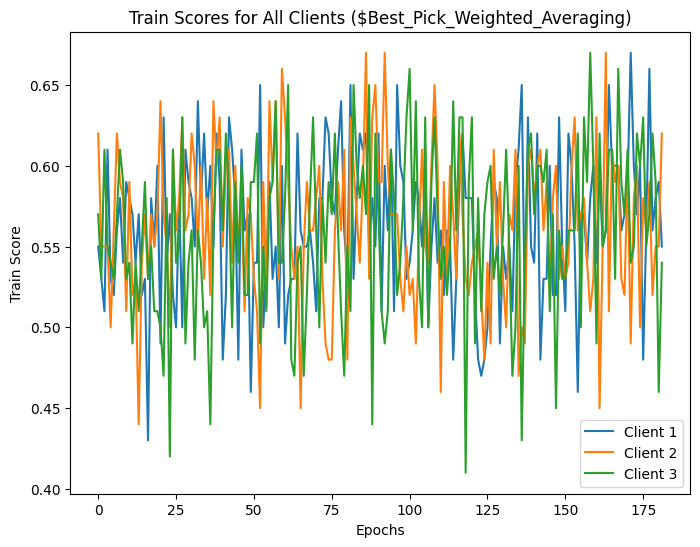

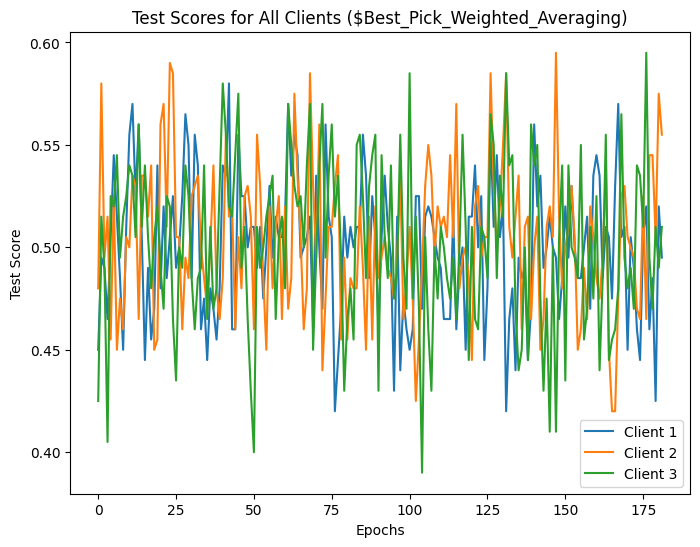

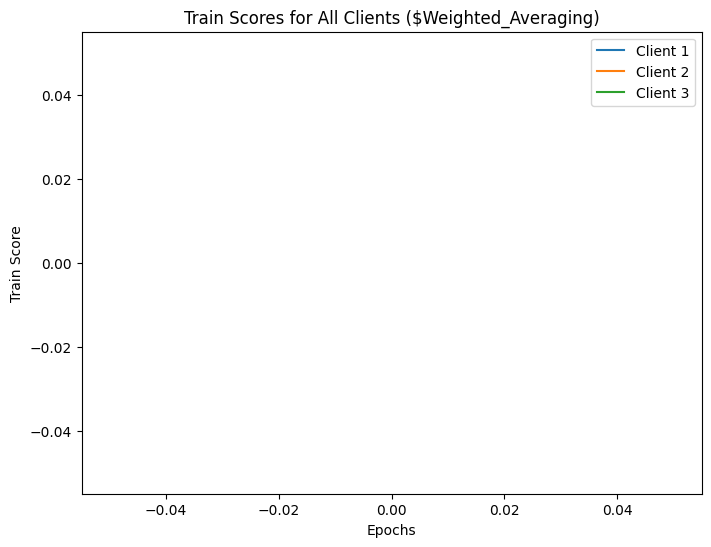

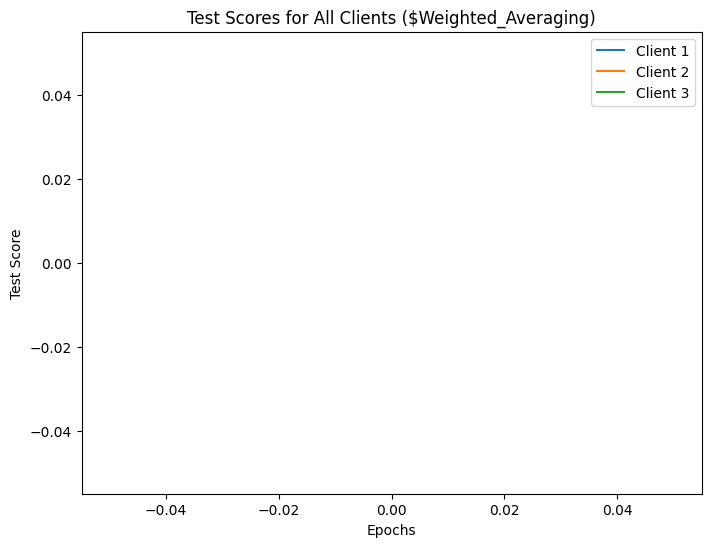

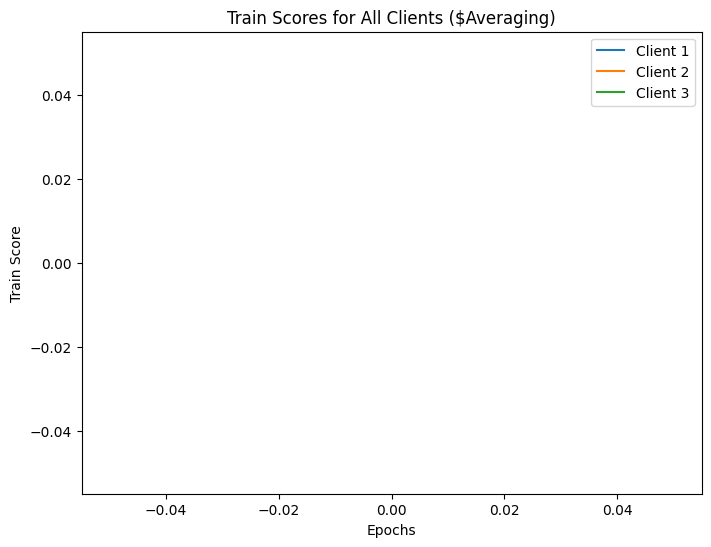

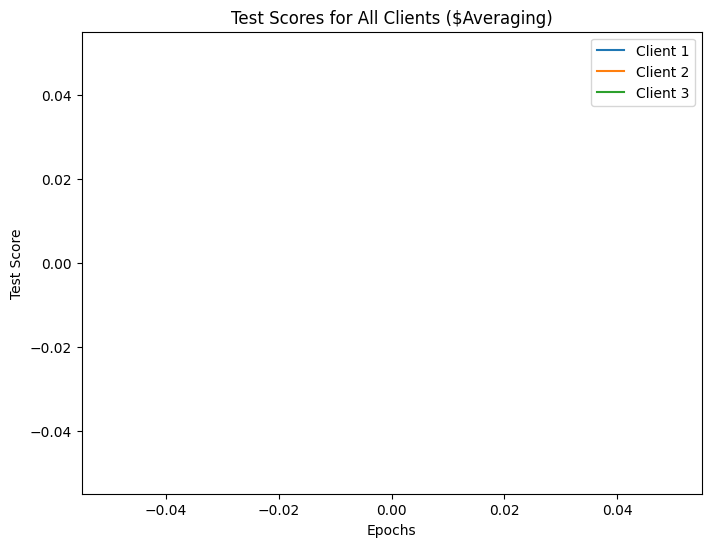

In [23]:
import matplotlib.pyplot as plt

# Create two figures, one for train scores and one for test scores

for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot train scores for all clients
  for client in clients:
      plt.plot(client.train_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Train Score')
  plt.title(f"Train Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the train scores plot
  plt.show()

  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))

  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  plt.xlabel('Epochs')
  plt.ylabel('Test Score')
  plt.title(f"Test Scores for All Clients (${technique_name})")
  plt.legend()

  # Show the test scores plot
  plt.show()


## Visualization of Client Training Scores

In this code, we create visualizations to testing scores of each client and the global model across different epochs.


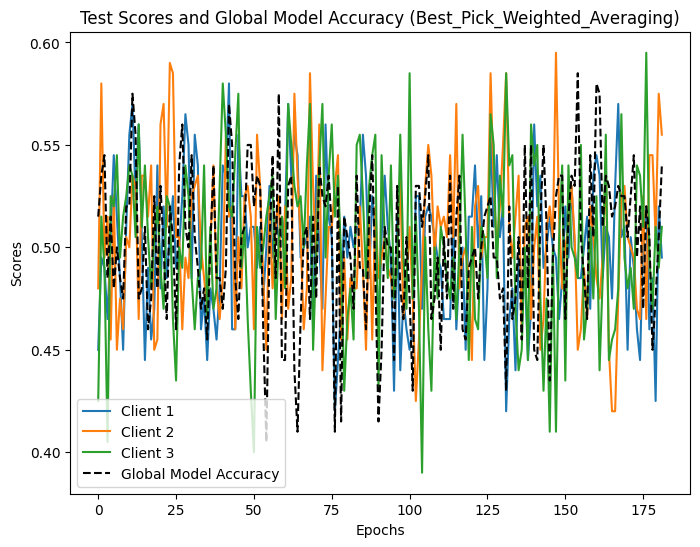

IndexError: list index out of range

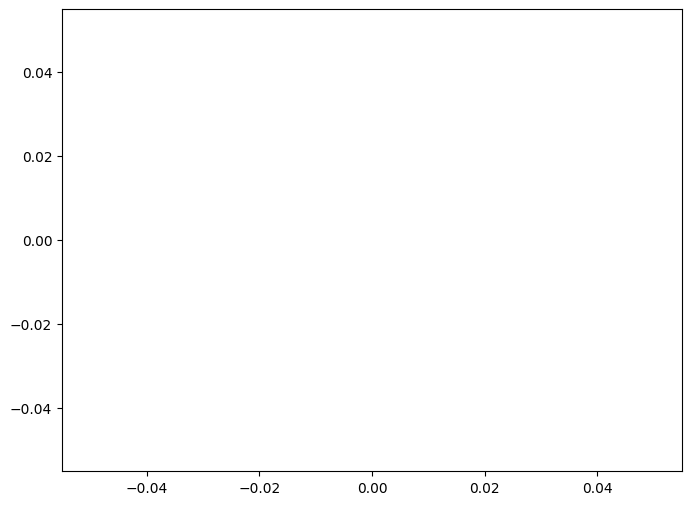

In [24]:
import matplotlib.pyplot as plt


for idx, clients in enumerate(clients_2d_array):

  technique_name = list(fl_techniques.keys())[idx]
  # Create a new figure for test scores
  plt.figure(figsize=(8, 6))


  # Plot test scores for all clients
  for client in clients:
      plt.plot(client.test_scores, label=f'Client {clients.index(client) + 1}')

  # Plot global model accuracy
  plt.plot(global_model_accuracy[idx], label='Global Model Accuracy', linestyle='--', color='black')

  plt.xlabel('Epochs')
  plt.ylabel('Scores')
  plt.title(f"Test Scores and Global Model Accuracy ({technique_name})")
  plt.legend()

  # Show the combined graph
  plt.show()


In [25]:
np_final_test_data = np_data_set[50000:]

final_test_sequences = [data_point["sequence"] for data_point in np_final_test_data]
final_test_labels = [data_point["label"] for data_point in np_final_test_data]
final_test_sequences = np.array(final_test_sequences)
final_test_labels = np.array(final_test_labels)

def getFinalAccuracy(weights):
        num_features = len(test_sequences[0])
        feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
        ansatz = RealAmplitudes(num_qubits=num_features, reps=ansatz_reps)
        optimizer = COBYLA(maxiter=0)
        vqc = VQC(
            feature_map=feature_map,
            ansatz=ansatz,
            optimizer=optimizer,
            initial_point = weights,
            sampler=BackendSampler(backend=backend)
        )
        vqc.fit(test_sequences[:25], test_labels[:25])
        return vqc.score(final_test_sequences, final_test_labels)

In [26]:
final_results = []
for idx, row in enumerate(global_model_weights):
  final_results.append([])
  for global_model_weight in row:
    final_results[idx].append(getFinalAccuracy(global_model_weight))
print(final_results)

C:\Users\18706\AppData\Local\Temp\ipykernel_13440\600496728.py:18: DeprecationWarning: The class ``qiskit.primitives.backend_sampler.BackendSampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `BackendSampler` class is `BackendSamplerV2`.
  sampler=BackendSampler(backend=backend)


QiskitMachineLearningError: 'Sampler job failed.'

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming final_results is a 2D array containing your data
final_results = np.array(final_results)  # Convert final_results to a NumPy array

plt.figure(figsize=(10, 8))

# Iterate through each row and plot it
for row_index in range(final_results.shape[0]):
    data_row = final_results[row_index]
    technique_name = list(fl_techniques.keys())[row_index]
    plt.plot(data_row, label=f'Global Model Accuracy For: {technique_name}')

plt.xlabel('Column Index')
plt.ylabel('Value')
plt.title('Global Model Accuracy')
plt.legend()
plt.show()
